In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gen-disc/best_G (1).pth
/kaggle/input/gen-disc/best_D (1).pth
/kaggle/input/kaggle-key/kaggle.json
/kaggle/input/mdlthree00/model_stateGen_300.pth
/kaggle/input/mdlthree00/model_stateDisc_300.pth


In [19]:
!pip install opendatasets --upgrade --quiet

In [20]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/sunnykusawa/tshirts'
od.download(dataset_url)

Skipping, found downloaded files in "./tshirts" (use force=True to force download)


In [21]:
import os

DATA_DIR = './tshirts'
print(os.listdir(DATA_DIR))

['tshirt']


In [22]:
print(os.listdir(DATA_DIR+'/tshirt')[:10])

['1494.jpg', '798.jpg', '391.jpg', '1113.jpg', '1052.jpg', '1237.jpg', '987.jpg', '1923.jpg', '1540.jpg', '1443.jpg']


In [23]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [24]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [25]:
# Define data augmentation transformations
data_transforms = T.Compose([
    T.RandomResizedCrop(image_size),  # Randomly resize and crop
    T.RandomHorizontalFlip(),         # Randomly flip horizontally
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    T.RandomRotation(10),             # Randomly rotate by up to 10 degrees
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    T.RandomPerspective(),            # Random perspective transform
    T.ToTensor(),
    T.Normalize(*stats)
])

# Create the training dataset with data augmentation
train_ds = ImageFolder(DATA_DIR, transform=data_transforms)

# Create the data loader
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)


# Create the training dataset with data augmentation
train_ds = ImageFolder(DATA_DIR, transform=data_transforms)

# Create the data loader
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
, pin_memory=True)

'pin_memory=True)'

In [26]:
image,label  = train_ds[1]

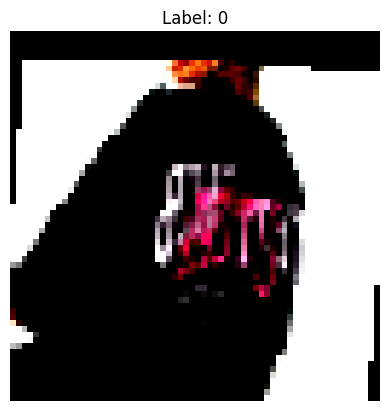

In [27]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(image, (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C) for display
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [28]:
import torch
from torchvision.utils import make_grid
%matplotlib inline

In [29]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [30]:
print(stats[1][0], stats[0][0])

0.5 0.5


In [31]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

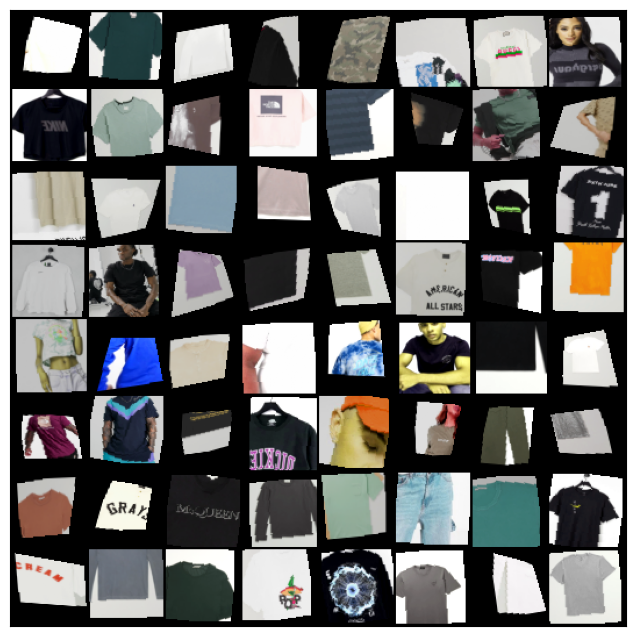

In [32]:
import matplotlib.pyplot as plt
show_batch(train_dl)

GPU checks

In [33]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [34]:
device = get_default_device()
device

device(type='cuda')

In [35]:
train_dl = DeviceDataLoader(train_dl, device)

In [36]:
import torch.nn as nn
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [37]:
discriminator = to_device(discriminator, device)

lets make generator, first we initialize our generator to random values

In [38]:
latent_size = 128

In [39]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

we can see below perfectly random noise

torch.Size([128, 3, 64, 64])


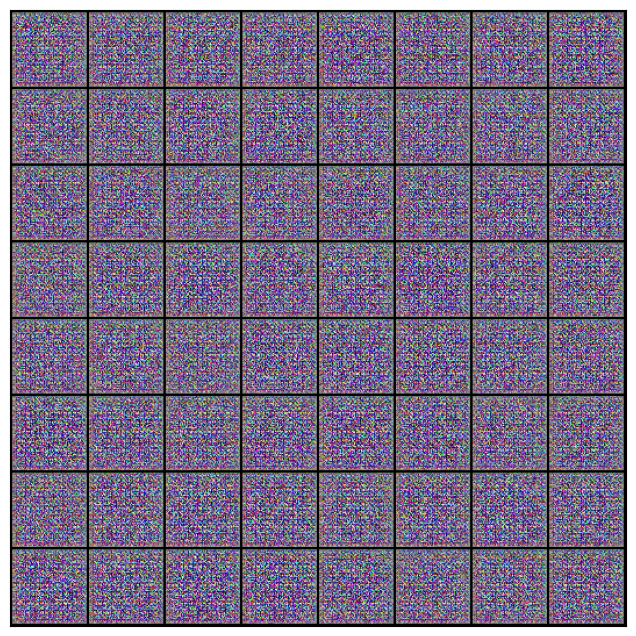

In [40]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors

fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

Now lets come to training our generator

In [41]:
generator = to_device(generator,device)

In [42]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [43]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()#find gradient
    opt_g.step()
    
    return loss.item()

In [44]:
from torchvision.utils import save_image

in gans we dont have a validation set to find how accurate output is so here we save samples of generated image in a file to see later

In [45]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [46]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [47]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


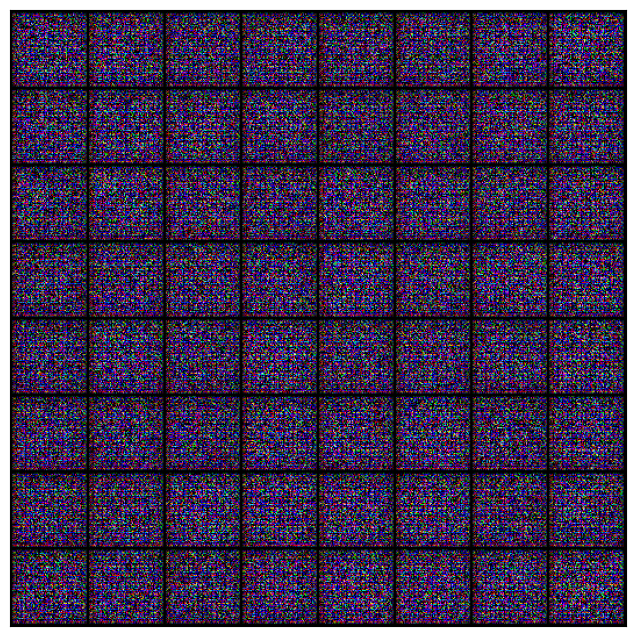

In [48]:
save_samples(0, fixed_latent)

In [49]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

THERE IS A SKIGHT IUSSUE WITH THE LOOP STRUCTURE OIF THIS FIT FUNCTION

In [50]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        
    # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [51]:
lr = 0.00002
epochs = 100

In [52]:
import os

# Set the directory where you want to save your model checkpoints
checkpoint_dir = '/kaggle/working/checkpoints/'

# Make sure the directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

In [53]:
"""# Initialize variables to keep track of the best model and its performance
best_generator_loss = float('inf')  # Initialize with a high value
best_epoch = None

# Set the directory where you want to save your model checkpoints
checkpoint_dir = 'A:/checkpoints'

# Make sure the directory exists
import os
os.makedirs(checkpoint_dir, exist_ok=True)

# Training loop
for epoch in range(epochs):
    # Training code here (use your fit function or training loop)
    history = fit(epochs, lr)

    # Calculate and monitor relevant metrics (e.g., generator loss)
    losses_g, losses_d, real_scores, fake_scores = history

    # Get the generator loss for the last epoch
    last_epoch_generator_loss = losses_g[-1]

    # Check if the current model is the best so far
    if last_epoch_generator_loss < best_generator_loss:
        best_generator_loss = last_epoch_generator_loss
        best_epoch = epoch
        
        # Save the best generator and discriminator state_dicts
        torch.save(generator.state_dict(), os.path.join(checkpoint_dir, 'best_G.pth'))
        torch.save(discriminator.state_dict(), os.path.join(checkpoint_dir, 'best_D.pth'))
"""


"# Initialize variables to keep track of the best model and its performance\nbest_generator_loss = float('inf')  # Initialize with a high value\nbest_epoch = None\n\n# Set the directory where you want to save your model checkpoints\ncheckpoint_dir = 'A:/checkpoints'\n\n# Make sure the directory exists\nimport os\nos.makedirs(checkpoint_dir, exist_ok=True)\n\n# Training loop\nfor epoch in range(epochs):\n    # Training code here (use your fit function or training loop)\n    history = fit(epochs, lr)\n\n    # Calculate and monitor relevant metrics (e.g., generator loss)\n    losses_g, losses_d, real_scores, fake_scores = history\n\n    # Get the generator loss for the last epoch\n    last_epoch_generator_loss = losses_g[-1]\n\n    # Check if the current model is the best so far\n    if last_epoch_generator_loss < best_generator_loss:\n        best_generator_loss = last_epoch_generator_loss\n        best_epoch = epoch\n        \n        # Save the best generator and discriminator state_di

In [54]:
"""# After training completes, you can load the best model like this:
if best_epoch is not None:
    generator.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'best_G.pth')))
    discriminator.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'best_D.pth')))


"history = fit(epochs, lr)
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')""
"""

'# After training completes, you can load the best model like this:\nif best_epoch is not None:\n    generator.load_state_dict(torch.load(os.path.join(checkpoint_dir, \'best_G.pth\')))\n    discriminator.load_state_dict(torch.load(os.path.join(checkpoint_dir, \'best_D.pth\')))\n\n\n"history = fit(epochs, lr)\n# Save the model checkpoints \ntorch.save(generator.state_dict(), \'G.pth\')\ntorch.save(discriminator.state_dict(), \'D.pth\')""\n'

In [55]:
"""# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')"""

"# Save the model checkpoints \ntorch.save(generator.state_dict(), 'G.pth')\ntorch.save(discriminator.state_dict(), 'D.pth')"

our loss_d is very small, this cannot be a good sign at very initial stages so there can be some issues: 1-vanishing gradient(can resolve it with smaller batch size) 2-lower the lr

In [56]:
"""epochs = 100
lr = 0.00002
from tqdm import tqdm
best_generator_loss = float('inf')  # Initialize with a high value
best_epoch = None

# Set the directory where you want to save your model checkpoints
checkpoint_dir = 'checkpoints'

# Make sure the directory exists
import os
os.makedirs(checkpoint_dir, exist_ok=True)
for epoch in range(epochs):
    # Training code here (use your fit function or training loop)
    history = fit(epochs, lr)

    # Calculate and monitor relevant metrics (e.g., generator loss)
    losses_g, losses_d, real_scores, fake_scores = history

    # Get the generator loss for the last epoch
    last_epoch_generator_loss = losses_g[-1]

    # Check if the current model is the best so far
    if last_epoch_generator_loss < best_generator_loss:
        best_generator_loss = last_epoch_generator_loss
        best_epoch = epoch
        
        # Save the best generator and discriminator state_dicts
        torch.save(generator.state_dict(), f'generator_epoch_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'discriminator_epoch_{epoch}.pth')"""

"epochs = 100\nlr = 0.00002\nfrom tqdm import tqdm\nbest_generator_loss = float('inf')  # Initialize with a high value\nbest_epoch = None\n\n# Set the directory where you want to save your model checkpoints\ncheckpoint_dir = 'checkpoints'\n\n# Make sure the directory exists\nimport os\nos.makedirs(checkpoint_dir, exist_ok=True)\nfor epoch in range(epochs):\n    # Training code here (use your fit function or training loop)\n    history = fit(epochs, lr)\n\n    # Calculate and monitor relevant metrics (e.g., generator loss)\n    losses_g, losses_d, real_scores, fake_scores = history\n\n    # Get the generator loss for the last epoch\n    last_epoch_generator_loss = losses_g[-1]\n\n    # Check if the current model is the best so far\n    if last_epoch_generator_loss < best_generator_loss:\n        best_generator_loss = last_epoch_generator_loss\n        best_epoch = epoch\n        \n        # Save the best generator and discriminator state_dicts\n        torch.save(generator.state_dict(),

In [57]:
"""# Load the saved generator and discriminator models  
generator.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'current_G.pth')))
discriminator.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'current_D.pth')))"""


"# Load the saved generator and discriminator models  \ngenerator.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'current_G.pth')))\ndiscriminator.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'current_D.pth')))"

In [58]:
"""import torch
import torch.nn as nn
from your_generator_module import generator  # Replace with your actual module and class


# Load the state dictionary of your generator from the saved checkpoint
checkpoint_path = 'path/to/your/saved/G.pth'
generator.load_state_dict(torch.load(checkpoint_path))"""


"import torch\nimport torch.nn as nn\nfrom your_generator_module import generator  # Replace with your actual module and class\n\n\n# Load the state dictionary of your generator from the saved checkpoint\ncheckpoint_path = 'path/to/your/saved/G.pth'\ngenerator.load_state_dict(torch.load(checkpoint_path))"

LOAD DISCRIMINATOR AND GENERATOR

In [59]:
"""# Load the state_dict from the saved checkpoint
checkpoint = torch.load('/kaggle/input/model200/model_stateGen_200.pth')

# Create a new state_dict that maps loaded weights to the current model's layers
new_state_dict = {}
for name, param in checkpoint.items():
    if name in generator.state_dict():
        if param.shape == generator.state_dict()[name].shape:
            new_state_dict[name] = param

# Load the modified state_dict into the generator
generator.load_state_dict(new_state_dict)

# Put your model in evaluation mode
generator.eval()
"""

"# Load the state_dict from the saved checkpoint\ncheckpoint = torch.load('/kaggle/input/model200/model_stateGen_200.pth')\n\n# Create a new state_dict that maps loaded weights to the current model's layers\nnew_state_dict = {}\nfor name, param in checkpoint.items():\n    if name in generator.state_dict():\n        if param.shape == generator.state_dict()[name].shape:\n            new_state_dict[name] = param\n\n# Load the modified state_dict into the generator\ngenerator.load_state_dict(new_state_dict)\n\n# Put your model in evaluation mode\ngenerator.eval()\n"

In [60]:
"""# Load the state_dict from the saved checkpoint
checkpoint = torch.load('/kaggle/input/model200/model_stateDisc_200.pth')

# Create a new state_dict that maps loaded weights to the current model's layers
new_state_dict = {}
for name, param in checkpoint.items():
    if name in generator.state_dict():
        if param.shape == discriminator.state_dict()[name].shape:
            new_state_dict[name] = param

# Load the modified state_dict into the generator
discriminator.load_state_dict(new_state_dict)

# Put your model in evaluation mode
discriminator.eval()"""


"# Load the state_dict from the saved checkpoint\ncheckpoint = torch.load('/kaggle/input/model200/model_stateDisc_200.pth')\n\n# Create a new state_dict that maps loaded weights to the current model's layers\nnew_state_dict = {}\nfor name, param in checkpoint.items():\n    if name in generator.state_dict():\n        if param.shape == discriminator.state_dict()[name].shape:\n            new_state_dict[name] = param\n\n# Load the modified state_dict into the generator\ndiscriminator.load_state_dict(new_state_dict)\n\n# Put your model in evaluation mode\ndiscriminator.eval()"

In [61]:
"""#renaming a file
import os

# Define the current and new file names
current_name = 'best'
new_name = 'new_filename.ext'

# Rename the file
os.rename(current_name, new_name)"""

"#renaming a file\nimport os\n\n# Define the current and new file names\ncurrent_name = 'best'\nnew_name = 'new_filename.ext'\n\n# Rename the file\nos.rename(current_name, new_name)"

In [62]:
!pip install tqdm

In [63]:
"""epochs = "SET EPOCH NUMBER"
lr = 0.00002
from tqdm import tqdm
best_generator_loss = float('inf')  # Initialize with a high value
best_epoch = None

# Set the directory where you want to save your model checkpoints
checkpoint_dir = 'checkpoints'

# Make sure the directory exists
import os
os.makedirs(checkpoint_dir, exist_ok=True)
for epoch in range(epochs):
    # Training code here (use your fit function or training loop)
    history = fit(epochs, lr)

    # Calculate and monitor relevant metrics (e.g., generator loss)
    losses_g, losses_d, real_scores, fake_scores = history

    # Get the generator loss for the last epoch
    last_epoch_generator_loss = losses_g[-1]

    # Check if the current model is the best so far
    if last_epoch_generator_loss < best_generator_loss:
        best_generator_loss = last_epoch_generator_loss
        best_epoch = epoch
        
        # Save the best generator and discriminator state_dicts
        torch.save(generator.state_dict(), f'generator_epoch_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'discriminator_epoch_{epoch}.pth')"""

'epochs = "SET EPOCH NUMBER"\nlr = 0.00002\nfrom tqdm import tqdm\nbest_generator_loss = float(\'inf\')  # Initialize with a high value\nbest_epoch = None\n\n# Set the directory where you want to save your model checkpoints\ncheckpoint_dir = \'checkpoints\'\n\n# Make sure the directory exists\nimport os\nos.makedirs(checkpoint_dir, exist_ok=True)\nfor epoch in range(epochs):\n    # Training code here (use your fit function or training loop)\n    history = fit(epochs, lr)\n\n    # Calculate and monitor relevant metrics (e.g., generator loss)\n    losses_g, losses_d, real_scores, fake_scores = history\n\n    # Get the generator loss for the last epoch\n    last_epoch_generator_loss = losses_g[-1]\n\n    # Check if the current model is the best so far\n    if last_epoch_generator_loss < best_generator_loss:\n        best_generator_loss = last_epoch_generator_loss\n        best_epoch = epoch\n        \n        # Save the best generator and discriminator state_dicts\n        torch.save(gene

In [64]:
"""# Save the state dictionary of your model
torch.save(discriminator.state_dict(), 'model_stateDisc_300.pth')
torch.save(generator.state_dict(), 'model_stateGen_300.pth')
"""

"# Save the state dictionary of your model\ntorch.save(discriminator.state_dict(), 'model_stateDisc_300.pth')\ntorch.save(generator.state_dict(), 'model_stateGen_300.pth')\n"

In [65]:
"""losses_g, losses_d, real_scores, fake_scores = history"""

'losses_g, losses_d, real_scores, fake_scores = history'

In [66]:
"""plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');"""

"plt.plot(losses_d, '-')\nplt.plot(losses_g, '-')\nplt.xlabel('epoch')\nplt.ylabel('loss')\nplt.legend(['Discriminator', 'Generator'])\nplt.title('Losses');"

In [67]:
"""plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');"""

"plt.plot(real_scores, '-')\nplt.plot(fake_scores, '-')\nplt.xlabel('epoch')\nplt.ylabel('score')\nplt.legend(['Real', 'Fake'])\nplt.title('Scores');"

In [68]:
"""# Create a dictionary to store training progress
training_progress = {
    'epoch': epoch,
    'model_state_dict': generator.state_dict(),
    #'optimizer_state_dict': optimizer.state_dict(),
    'history':history
    #'loss': loss,
    # Add other relevant information here
}

# Save the training progress
torch.save(training_progress, 'training_progress.pth')"""


"# Create a dictionary to store training progress\ntraining_progress = {\n    'epoch': epoch,\n    'model_state_dict': generator.state_dict(),\n    #'optimizer_state_dict': optimizer.state_dict(),\n    'history':history\n    #'loss': loss,\n    # Add other relevant information here\n}\n\n# Save the training progress\ntorch.save(training_progress, 'training_progress.pth')"

load discriminator and generator from your pc

In [69]:
# Load the state_dict from the saved checkpoint
checkpoint = torch.load('/kaggle/input/mdlthree00/model_stateGen_300.pth')

# Create a new state_dict that maps loaded weights to the current model's layers
new_state_dict = {}
for name, param in checkpoint.items():
    if name in generator.state_dict():
        if param.shape == generator.state_dict()[name].shape:
            new_state_dict[name] = param

# Load the modified state_dict into the generator
generator.load_state_dict(new_state_dict)

# Put your model in evaluation mode
generator.eval()


Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [70]:
# Load the state_dict from the saved checkpoint
checkpoint = torch.load('/kaggle/input/mdlthree00/model_stateDisc_300.pth')

# Create a new state_dict that maps loaded weights to the current model's layers
new_state_dict = {}
for name, param in checkpoint.items():
    if name in discriminator.state_dict():
        if param.shape == discriminator.state_dict()[name].shape:
            new_state_dict[name] = param

# Load the modified state_dict into the generator
discriminator.load_state_dict(new_state_dict)

# Put your model in evaluation mode
discriminator.eval()


Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

CODE FOR EPOCHS BELOW

In [71]:
epochs = 500
lr = 0.00002
from tqdm import tqdm
best_generator_loss = float('inf')  # Initialize with a high value
best_epoch = None

# Set the directory where you want to save your model checkpoints
checkpoint_dir = 'checkpoints'

# Make sure the directory exists
import os
os.makedirs(checkpoint_dir, exist_ok=True)
for epoch in range(epochs):
    # Training code here (use your fit function or training loop)
    history = fit(epochs, lr)

    # Calculate and monitor relevant metrics (e.g., generator loss)
    losses_g, losses_d, real_scores, fake_scores = history

    # Get the generator loss for the last epoch
    last_epoch_generator_loss = losses_g[-1]

    # Check if the current model is the best so far
    if last_epoch_generator_loss < best_generator_loss:
        best_generator_loss = last_epoch_generator_loss
        best_epoch = epoch
        
        # Save the best generator and discriminator state_dicts
        torch.save(generator.state_dict(), f'generator_epoch_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'discriminator_epoch_{epoch}.pth')

100%|██████████| 16/16 [00:42<00:00,  2.67s/it]


Epoch [1/500], loss_g: 3.4628, loss_d: 0.1857, real_score: 0.9307, fake_score: 0.0275
Saving generated-images-0001.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [2/500], loss_g: 4.6913, loss_d: 0.2122, real_score: 0.9153, fake_score: 0.0106
Saving generated-images-0002.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [3/500], loss_g: 4.5233, loss_d: 0.2121, real_score: 0.9668, fake_score: 0.1249
Saving generated-images-0003.png


100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


Epoch [4/500], loss_g: 3.4015, loss_d: 0.1868, real_score: 0.9527, fake_score: 0.0803
Saving generated-images-0004.png


100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


Epoch [5/500], loss_g: 5.4645, loss_d: 0.2260, real_score: 0.9211, fake_score: 0.0129
Saving generated-images-0005.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [6/500], loss_g: 4.9860, loss_d: 0.1414, real_score: 0.9745, fake_score: 0.0611
Saving generated-images-0006.png


100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


Epoch [7/500], loss_g: 3.2914, loss_d: 0.1331, real_score: 0.9468, fake_score: 0.0460
Saving generated-images-0007.png


100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


Epoch [8/500], loss_g: 2.9860, loss_d: 0.1793, real_score: 0.9185, fake_score: 0.0337
Saving generated-images-0008.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [9/500], loss_g: 4.3831, loss_d: 0.0872, real_score: 0.9723, fake_score: 0.0454
Saving generated-images-0009.png


100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


Epoch [10/500], loss_g: 3.1739, loss_d: 0.1411, real_score: 0.9425, fake_score: 0.0436
Saving generated-images-0010.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [11/500], loss_g: 8.4844, loss_d: 0.5205, real_score: 0.8239, fake_score: 0.0094
Saving generated-images-0011.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [12/500], loss_g: 3.6785, loss_d: 0.1725, real_score: 0.9387, fake_score: 0.0292
Saving generated-images-0012.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [13/500], loss_g: 3.5457, loss_d: 0.1712, real_score: 0.9268, fake_score: 0.0341
Saving generated-images-0013.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [14/500], loss_g: 3.1610, loss_d: 0.3414, real_score: 0.8873, fake_score: 0.0136
Saving generated-images-0014.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [15/500], loss_g: 4.3524, loss_d: 0.1190, real_score: 0.9533, fake_score: 0.0316
Saving generated-images-0015.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [16/500], loss_g: 3.4020, loss_d: 0.1066, real_score: 0.9594, fake_score: 0.0386
Saving generated-images-0016.png


100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


Epoch [17/500], loss_g: 3.0886, loss_d: 0.2642, real_score: 0.9052, fake_score: 0.0471
Saving generated-images-0017.png


100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


Epoch [18/500], loss_g: 4.0531, loss_d: 0.1216, real_score: 0.9523, fake_score: 0.0300
Saving generated-images-0018.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [19/500], loss_g: 3.6926, loss_d: 0.1421, real_score: 0.9173, fake_score: 0.0246
Saving generated-images-0019.png


100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


Epoch [20/500], loss_g: 3.7792, loss_d: 0.1485, real_score: 0.9495, fake_score: 0.0604
Saving generated-images-0020.png


100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


Epoch [21/500], loss_g: 4.4845, loss_d: 0.0898, real_score: 0.9483, fake_score: 0.0165
Saving generated-images-0021.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [22/500], loss_g: 4.4348, loss_d: 0.1869, real_score: 0.9768, fake_score: 0.1300
Saving generated-images-0022.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [23/500], loss_g: 3.6866, loss_d: 0.2133, real_score: 0.9273, fake_score: 0.0895
Saving generated-images-0023.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [24/500], loss_g: 4.5318, loss_d: 0.1837, real_score: 0.9614, fake_score: 0.0959
Saving generated-images-0024.png


100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


Epoch [25/500], loss_g: 6.6030, loss_d: 0.2602, real_score: 0.9757, fake_score: 0.1616
Saving generated-images-0025.png


100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


Epoch [26/500], loss_g: 3.3448, loss_d: 0.1976, real_score: 0.9287, fake_score: 0.0346
Saving generated-images-0026.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [27/500], loss_g: 2.6665, loss_d: 0.2518, real_score: 0.8950, fake_score: 0.0453
Saving generated-images-0027.png


100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


Epoch [28/500], loss_g: 4.7156, loss_d: 0.1543, real_score: 0.9721, fake_score: 0.0953
Saving generated-images-0028.png


100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


Epoch [29/500], loss_g: 4.0094, loss_d: 0.2553, real_score: 0.9150, fake_score: 0.0171
Saving generated-images-0029.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [30/500], loss_g: 3.0826, loss_d: 0.1494, real_score: 0.9381, fake_score: 0.0443
Saving generated-images-0030.png


100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


Epoch [31/500], loss_g: 3.3095, loss_d: 0.1781, real_score: 0.9301, fake_score: 0.0374
Saving generated-images-0031.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [32/500], loss_g: 4.2005, loss_d: 0.1745, real_score: 0.9552, fake_score: 0.0899
Saving generated-images-0032.png


100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


Epoch [33/500], loss_g: 2.2324, loss_d: 0.2233, real_score: 0.9085, fake_score: 0.0286
Saving generated-images-0033.png


100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


Epoch [34/500], loss_g: 5.6813, loss_d: 0.3812, real_score: 0.8798, fake_score: 0.0039
Saving generated-images-0034.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [35/500], loss_g: 2.2414, loss_d: 0.2719, real_score: 0.8703, fake_score: 0.0192
Saving generated-images-0035.png


100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


Epoch [36/500], loss_g: 5.5865, loss_d: 0.1132, real_score: 0.9789, fake_score: 0.0758
Saving generated-images-0036.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [37/500], loss_g: 5.4544, loss_d: 0.0655, real_score: 0.9601, fake_score: 0.0115
Saving generated-images-0037.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [38/500], loss_g: 3.7498, loss_d: 0.2404, real_score: 0.9515, fake_score: 0.1106
Saving generated-images-0038.png


100%|██████████| 16/16 [00:42<00:00,  2.68s/it]


Epoch [39/500], loss_g: 3.8824, loss_d: 0.1740, real_score: 0.9606, fake_score: 0.1059
Saving generated-images-0039.png


100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


Epoch [40/500], loss_g: 4.9378, loss_d: 0.1098, real_score: 0.9597, fake_score: 0.0297
Saving generated-images-0040.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [41/500], loss_g: 4.3784, loss_d: 0.0873, real_score: 0.9715, fake_score: 0.0452
Saving generated-images-0041.png


100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


Epoch [42/500], loss_g: 2.7986, loss_d: 0.1985, real_score: 0.9031, fake_score: 0.0320
Saving generated-images-0042.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [43/500], loss_g: 4.3366, loss_d: 0.1606, real_score: 0.9516, fake_score: 0.0335
Saving generated-images-0043.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [44/500], loss_g: 4.8744, loss_d: 0.1722, real_score: 0.9554, fake_score: 0.0783
Saving generated-images-0044.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [45/500], loss_g: 4.9841, loss_d: 0.2887, real_score: 0.9578, fake_score: 0.1650
Saving generated-images-0045.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [46/500], loss_g: 1.2758, loss_d: 0.2028, real_score: 0.9182, fake_score: 0.0433
Saving generated-images-0046.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [47/500], loss_g: 4.1447, loss_d: 0.1888, real_score: 0.9403, fake_score: 0.0571
Saving generated-images-0047.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [48/500], loss_g: 3.8654, loss_d: 0.1887, real_score: 0.9502, fake_score: 0.0728
Saving generated-images-0048.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [49/500], loss_g: 5.2137, loss_d: 0.2692, real_score: 0.9794, fake_score: 0.1719
Saving generated-images-0049.png


100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


Epoch [50/500], loss_g: 3.8064, loss_d: 0.1561, real_score: 0.9405, fake_score: 0.0456
Saving generated-images-0050.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [51/500], loss_g: 3.2143, loss_d: 0.1570, real_score: 0.9264, fake_score: 0.0406
Saving generated-images-0051.png


100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


Epoch [52/500], loss_g: 2.8840, loss_d: 0.2340, real_score: 0.9194, fake_score: 0.0815
Saving generated-images-0052.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [53/500], loss_g: 2.2948, loss_d: 0.3084, real_score: 0.8691, fake_score: 0.0453
Saving generated-images-0053.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [54/500], loss_g: 2.9109, loss_d: 0.2168, real_score: 0.9022, fake_score: 0.0234
Saving generated-images-0054.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [55/500], loss_g: 3.4553, loss_d: 0.1695, real_score: 0.9395, fake_score: 0.0288
Saving generated-images-0055.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [56/500], loss_g: 1.6262, loss_d: 0.3515, real_score: 0.8518, fake_score: 0.0238
Saving generated-images-0056.png


100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


Epoch [57/500], loss_g: 3.0620, loss_d: 0.2512, real_score: 0.9175, fake_score: 0.0767
Saving generated-images-0057.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [58/500], loss_g: 3.4691, loss_d: 0.1688, real_score: 0.9537, fake_score: 0.0875
Saving generated-images-0058.png


100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


Epoch [59/500], loss_g: 2.6753, loss_d: 0.2632, real_score: 0.9130, fake_score: 0.0987
Saving generated-images-0059.png


100%|██████████| 16/16 [00:42<00:00,  2.67s/it]


Epoch [60/500], loss_g: 3.4172, loss_d: 0.2465, real_score: 0.9242, fake_score: 0.0562
Saving generated-images-0060.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [61/500], loss_g: 3.3956, loss_d: 0.2044, real_score: 0.9364, fake_score: 0.0579
Saving generated-images-0061.png


100%|██████████| 16/16 [00:43<00:00,  2.69s/it]


Epoch [62/500], loss_g: 4.9090, loss_d: 0.3148, real_score: 0.9583, fake_score: 0.1707
Saving generated-images-0062.png


100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


Epoch [63/500], loss_g: 4.3039, loss_d: 0.3013, real_score: 0.9445, fake_score: 0.1590
Saving generated-images-0063.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [64/500], loss_g: 2.2805, loss_d: 0.3020, real_score: 0.8947, fake_score: 0.0832
Saving generated-images-0064.png


100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


Epoch [65/500], loss_g: 5.5758, loss_d: 0.2398, real_score: 0.9650, fake_score: 0.1425
Saving generated-images-0065.png


100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


Epoch [66/500], loss_g: 4.3044, loss_d: 0.1481, real_score: 0.9561, fake_score: 0.0759
Saving generated-images-0066.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [67/500], loss_g: 6.2064, loss_d: 0.3314, real_score: 0.9811, fake_score: 0.2100
Saving generated-images-0067.png


100%|██████████| 16/16 [00:42<00:00,  2.68s/it]


Epoch [68/500], loss_g: 4.0834, loss_d: 0.1054, real_score: 0.9546, fake_score: 0.0327
Saving generated-images-0068.png


100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


Epoch [69/500], loss_g: 3.1205, loss_d: 0.3097, real_score: 0.8968, fake_score: 0.0236
Saving generated-images-0069.png


100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


Epoch [70/500], loss_g: 4.3184, loss_d: 0.2695, real_score: 0.9469, fake_score: 0.1382
Saving generated-images-0070.png


100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


Epoch [71/500], loss_g: 4.9871, loss_d: 0.1507, real_score: 0.9402, fake_score: 0.0329
Saving generated-images-0071.png


100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


Epoch [72/500], loss_g: 3.8911, loss_d: 0.1225, real_score: 0.9488, fake_score: 0.0481
Saving generated-images-0072.png


100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


Epoch [73/500], loss_g: 3.8140, loss_d: 0.2115, real_score: 0.9209, fake_score: 0.0482
Saving generated-images-0073.png


100%|██████████| 16/16 [00:42<00:00,  2.68s/it]


Epoch [74/500], loss_g: 3.8098, loss_d: 0.2002, real_score: 0.9423, fake_score: 0.0651
Saving generated-images-0074.png


100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


Epoch [75/500], loss_g: 4.0844, loss_d: 0.3075, real_score: 0.8957, fake_score: 0.0508
Saving generated-images-0075.png


100%|██████████| 16/16 [00:43<00:00,  2.69s/it]


Epoch [76/500], loss_g: 3.9560, loss_d: 0.1925, real_score: 0.9479, fake_score: 0.0355
Saving generated-images-0076.png


100%|██████████| 16/16 [00:42<00:00,  2.69s/it]


Epoch [77/500], loss_g: 3.4734, loss_d: 0.1790, real_score: 0.9510, fake_score: 0.0753
Saving generated-images-0077.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [78/500], loss_g: 4.0365, loss_d: 0.1598, real_score: 0.9690, fake_score: 0.0923
Saving generated-images-0078.png


100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


Epoch [79/500], loss_g: 4.4649, loss_d: 0.1767, real_score: 0.9443, fake_score: 0.0724
Saving generated-images-0079.png


100%|██████████| 16/16 [00:42<00:00,  2.68s/it]


Epoch [80/500], loss_g: 2.9808, loss_d: 0.1962, real_score: 0.9079, fake_score: 0.0440
Saving generated-images-0080.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [81/500], loss_g: 3.1553, loss_d: 0.1839, real_score: 0.9206, fake_score: 0.0229
Saving generated-images-0081.png


100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


Epoch [82/500], loss_g: 4.1144, loss_d: 0.1690, real_score: 0.9369, fake_score: 0.0563
Saving generated-images-0082.png


100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


Epoch [83/500], loss_g: 5.1867, loss_d: 0.1906, real_score: 0.9643, fake_score: 0.1002
Saving generated-images-0083.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [84/500], loss_g: 2.1319, loss_d: 0.3112, real_score: 0.8834, fake_score: 0.0275
Saving generated-images-0084.png


100%|██████████| 16/16 [00:42<00:00,  2.67s/it]


Epoch [85/500], loss_g: 3.5689, loss_d: 0.1908, real_score: 0.9420, fake_score: 0.0854
Saving generated-images-0085.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [86/500], loss_g: 3.1019, loss_d: 0.1962, real_score: 0.9203, fake_score: 0.0685
Saving generated-images-0086.png


100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


Epoch [87/500], loss_g: 2.6847, loss_d: 0.2736, real_score: 0.9087, fake_score: 0.0469
Saving generated-images-0087.png


100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


Epoch [88/500], loss_g: 3.1869, loss_d: 0.2192, real_score: 0.9243, fake_score: 0.0745
Saving generated-images-0088.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [89/500], loss_g: 5.9173, loss_d: 0.2009, real_score: 0.9782, fake_score: 0.1369
Saving generated-images-0089.png


100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


Epoch [90/500], loss_g: 2.8801, loss_d: 0.1770, real_score: 0.9324, fake_score: 0.0638
Saving generated-images-0090.png


100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


Epoch [91/500], loss_g: 3.1027, loss_d: 0.2251, real_score: 0.9487, fake_score: 0.1024
Saving generated-images-0091.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [92/500], loss_g: 3.0195, loss_d: 0.1978, real_score: 0.9116, fake_score: 0.0512
Saving generated-images-0092.png


100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


Epoch [93/500], loss_g: 5.2738, loss_d: 0.2290, real_score: 0.9619, fake_score: 0.1498
Saving generated-images-0093.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [94/500], loss_g: 3.8990, loss_d: 0.1699, real_score: 0.9536, fake_score: 0.0842
Saving generated-images-0094.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [95/500], loss_g: 3.1839, loss_d: 0.1333, real_score: 0.9566, fake_score: 0.0698
Saving generated-images-0095.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [96/500], loss_g: 3.0481, loss_d: 0.1877, real_score: 0.9158, fake_score: 0.0435
Saving generated-images-0096.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [97/500], loss_g: 2.4542, loss_d: 0.1813, real_score: 0.9302, fake_score: 0.0439
Saving generated-images-0097.png


100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


Epoch [98/500], loss_g: 2.7761, loss_d: 0.3409, real_score: 0.9238, fake_score: 0.1278
Saving generated-images-0098.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [99/500], loss_g: 4.7737, loss_d: 0.0851, real_score: 0.9610, fake_score: 0.0280
Saving generated-images-0099.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [100/500], loss_g: 2.7920, loss_d: 0.2657, real_score: 0.9235, fake_score: 0.0999
Saving generated-images-0100.png


100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


Epoch [101/500], loss_g: 7.0726, loss_d: 0.3781, real_score: 0.9846, fake_score: 0.2396
Saving generated-images-0101.png


100%|██████████| 16/16 [00:45<00:00,  2.81s/it]


Epoch [102/500], loss_g: 3.3533, loss_d: 0.2188, real_score: 0.9159, fake_score: 0.0502
Saving generated-images-0102.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [103/500], loss_g: 4.2103, loss_d: 0.1523, real_score: 0.9417, fake_score: 0.0394
Saving generated-images-0103.png


100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


Epoch [104/500], loss_g: 4.1689, loss_d: 0.2959, real_score: 0.8694, fake_score: 0.0139
Saving generated-images-0104.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [105/500], loss_g: 2.5688, loss_d: 0.2591, real_score: 0.9089, fake_score: 0.0659
Saving generated-images-0105.png


100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


Epoch [106/500], loss_g: 4.2702, loss_d: 0.2562, real_score: 0.9627, fake_score: 0.1715
Saving generated-images-0106.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [107/500], loss_g: 4.3087, loss_d: 0.1232, real_score: 0.9455, fake_score: 0.0491
Saving generated-images-0107.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [108/500], loss_g: 3.5512, loss_d: 0.2256, real_score: 0.9223, fake_score: 0.0389
Saving generated-images-0108.png


100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


Epoch [109/500], loss_g: 3.5398, loss_d: 0.1904, real_score: 0.9293, fake_score: 0.0666
Saving generated-images-0109.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [110/500], loss_g: 3.3304, loss_d: 0.2648, real_score: 0.8860, fake_score: 0.0350
Saving generated-images-0110.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [111/500], loss_g: 4.3685, loss_d: 0.1452, real_score: 0.9538, fake_score: 0.0722
Saving generated-images-0111.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [112/500], loss_g: 4.1841, loss_d: 0.2378, real_score: 0.9422, fake_score: 0.1132
Saving generated-images-0112.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [113/500], loss_g: 3.0676, loss_d: 0.1485, real_score: 0.9436, fake_score: 0.0648
Saving generated-images-0113.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [114/500], loss_g: 2.3023, loss_d: 0.2668, real_score: 0.8977, fake_score: 0.0688
Saving generated-images-0114.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [115/500], loss_g: 4.2764, loss_d: 0.1373, real_score: 0.9811, fake_score: 0.0995
Saving generated-images-0115.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [116/500], loss_g: 3.1912, loss_d: 0.2531, real_score: 0.8812, fake_score: 0.0201
Saving generated-images-0116.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [117/500], loss_g: 5.8304, loss_d: 0.3496, real_score: 0.8792, fake_score: 0.0087
Saving generated-images-0117.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [118/500], loss_g: 3.0872, loss_d: 0.1819, real_score: 0.9293, fake_score: 0.0712
Saving generated-images-0118.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [119/500], loss_g: 4.4564, loss_d: 0.1247, real_score: 0.9695, fake_score: 0.0726
Saving generated-images-0119.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [120/500], loss_g: 4.0990, loss_d: 0.1293, real_score: 0.9683, fake_score: 0.0748
Saving generated-images-0120.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [121/500], loss_g: 2.8406, loss_d: 0.2511, real_score: 0.8883, fake_score: 0.0163
Saving generated-images-0121.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [122/500], loss_g: 1.2716, loss_d: 0.4625, real_score: 0.8334, fake_score: 0.0217
Saving generated-images-0122.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [123/500], loss_g: 3.9352, loss_d: 0.2432, real_score: 0.9371, fake_score: 0.0581
Saving generated-images-0123.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [124/500], loss_g: 2.9291, loss_d: 0.1760, real_score: 0.9270, fake_score: 0.0523
Saving generated-images-0124.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [125/500], loss_g: 3.0534, loss_d: 0.2669, real_score: 0.9275, fake_score: 0.1158
Saving generated-images-0125.png


100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


Epoch [126/500], loss_g: 3.4771, loss_d: 0.1815, real_score: 0.9459, fake_score: 0.0705
Saving generated-images-0126.png


100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


Epoch [127/500], loss_g: 3.3357, loss_d: 0.1387, real_score: 0.9321, fake_score: 0.0247
Saving generated-images-0127.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [128/500], loss_g: 2.8479, loss_d: 0.3284, real_score: 0.8903, fake_score: 0.1067
Saving generated-images-0128.png


100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


Epoch [129/500], loss_g: 3.7048, loss_d: 0.3123, real_score: 0.8959, fake_score: 0.0452
Saving generated-images-0129.png


100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


Epoch [130/500], loss_g: 1.5550, loss_d: 0.3909, real_score: 0.8453, fake_score: 0.0648
Saving generated-images-0130.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [131/500], loss_g: 3.5537, loss_d: 0.1737, real_score: 0.9193, fake_score: 0.0420
Saving generated-images-0131.png


100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


Epoch [132/500], loss_g: 2.9637, loss_d: 0.1752, real_score: 0.9361, fake_score: 0.0409
Saving generated-images-0132.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [133/500], loss_g: 3.7393, loss_d: 0.2389, real_score: 0.9112, fake_score: 0.0419
Saving generated-images-0133.png


100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


Epoch [134/500], loss_g: 4.0777, loss_d: 0.2012, real_score: 0.9391, fake_score: 0.0765
Saving generated-images-0134.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [135/500], loss_g: 4.3099, loss_d: 0.2216, real_score: 0.9072, fake_score: 0.0398
Saving generated-images-0135.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [136/500], loss_g: 3.5154, loss_d: 0.1889, real_score: 0.9516, fake_score: 0.0966
Saving generated-images-0136.png


100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


Epoch [137/500], loss_g: 3.7164, loss_d: 0.2241, real_score: 0.9303, fake_score: 0.0723
Saving generated-images-0137.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [138/500], loss_g: 3.6454, loss_d: 0.2231, real_score: 0.9205, fake_score: 0.0770
Saving generated-images-0138.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [139/500], loss_g: 3.3576, loss_d: 0.3193, real_score: 0.9096, fake_score: 0.1015
Saving generated-images-0139.png


100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


Epoch [140/500], loss_g: 3.7084, loss_d: 0.3638, real_score: 0.8851, fake_score: 0.0209
Saving generated-images-0140.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [141/500], loss_g: 3.5297, loss_d: 0.2342, real_score: 0.9118, fake_score: 0.0813
Saving generated-images-0141.png


100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


Epoch [142/500], loss_g: 4.1647, loss_d: 0.2080, real_score: 0.9717, fake_score: 0.1518
Saving generated-images-0142.png


100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


Epoch [143/500], loss_g: 3.4530, loss_d: 0.2034, real_score: 0.9072, fake_score: 0.0513
Saving generated-images-0143.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [144/500], loss_g: 3.9898, loss_d: 0.1994, real_score: 0.9138, fake_score: 0.0300
Saving generated-images-0144.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [145/500], loss_g: 4.1464, loss_d: 0.1651, real_score: 0.9725, fake_score: 0.1195
Saving generated-images-0145.png


100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


Epoch [146/500], loss_g: 4.8408, loss_d: 0.1295, real_score: 0.9619, fake_score: 0.0536
Saving generated-images-0146.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [147/500], loss_g: 4.1920, loss_d: 0.3341, real_score: 0.9353, fake_score: 0.1485
Saving generated-images-0147.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [148/500], loss_g: 3.2783, loss_d: 0.1263, real_score: 0.9380, fake_score: 0.0329
Saving generated-images-0148.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [149/500], loss_g: 5.3619, loss_d: 0.1067, real_score: 0.9576, fake_score: 0.0345
Saving generated-images-0149.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [150/500], loss_g: 4.7438, loss_d: 0.3782, real_score: 0.8719, fake_score: 0.0131
Saving generated-images-0150.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [151/500], loss_g: 3.9700, loss_d: 0.1488, real_score: 0.9468, fake_score: 0.0666
Saving generated-images-0151.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [152/500], loss_g: 3.0268, loss_d: 0.2066, real_score: 0.9258, fake_score: 0.0589
Saving generated-images-0152.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [153/500], loss_g: 4.0119, loss_d: 0.1751, real_score: 0.9400, fake_score: 0.0471
Saving generated-images-0153.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [154/500], loss_g: 3.4123, loss_d: 0.4790, real_score: 0.8328, fake_score: 0.0060
Saving generated-images-0154.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [155/500], loss_g: 3.2119, loss_d: 0.2890, real_score: 0.8915, fake_score: 0.0390
Saving generated-images-0155.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [156/500], loss_g: 2.4476, loss_d: 0.3337, real_score: 0.8728, fake_score: 0.0570
Saving generated-images-0156.png


100%|██████████| 16/16 [00:46<00:00,  2.89s/it]


Epoch [157/500], loss_g: 1.9872, loss_d: 0.2525, real_score: 0.8844, fake_score: 0.0447
Saving generated-images-0157.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [158/500], loss_g: 2.5886, loss_d: 0.2813, real_score: 0.8773, fake_score: 0.0495
Saving generated-images-0158.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [159/500], loss_g: 3.6951, loss_d: 0.1604, real_score: 0.9280, fake_score: 0.0405
Saving generated-images-0159.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [160/500], loss_g: 2.1652, loss_d: 0.3234, real_score: 0.8518, fake_score: 0.0192
Saving generated-images-0160.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [161/500], loss_g: 2.4887, loss_d: 0.2468, real_score: 0.9015, fake_score: 0.0356
Saving generated-images-0161.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [162/500], loss_g: 4.0156, loss_d: 0.2422, real_score: 0.9319, fake_score: 0.0987
Saving generated-images-0162.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [163/500], loss_g: 5.2275, loss_d: 0.1546, real_score: 0.9194, fake_score: 0.0118
Saving generated-images-0163.png


100%|██████████| 16/16 [00:46<00:00,  2.92s/it]


Epoch [164/500], loss_g: 4.1601, loss_d: 0.2846, real_score: 0.9438, fake_score: 0.1620
Saving generated-images-0164.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [165/500], loss_g: 3.7694, loss_d: 0.2505, real_score: 0.9316, fake_score: 0.0916
Saving generated-images-0165.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [166/500], loss_g: 4.5571, loss_d: 0.3869, real_score: 0.9425, fake_score: 0.2268
Saving generated-images-0166.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [167/500], loss_g: 2.6866, loss_d: 0.2942, real_score: 0.8965, fake_score: 0.0694
Saving generated-images-0167.png


100%|██████████| 16/16 [00:46<00:00,  2.90s/it]


Epoch [168/500], loss_g: 3.8204, loss_d: 0.1536, real_score: 0.9717, fake_score: 0.1019
Saving generated-images-0168.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [169/500], loss_g: 2.2553, loss_d: 0.3229, real_score: 0.8888, fake_score: 0.0647
Saving generated-images-0169.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [170/500], loss_g: 4.4967, loss_d: 0.1418, real_score: 0.9719, fake_score: 0.0919
Saving generated-images-0170.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [171/500], loss_g: 4.5703, loss_d: 0.4431, real_score: 0.9327, fake_score: 0.2496
Saving generated-images-0171.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [172/500], loss_g: 3.8690, loss_d: 0.2505, real_score: 0.9388, fake_score: 0.1136
Saving generated-images-0172.png


100%|██████████| 16/16 [00:46<00:00,  2.90s/it]


Epoch [173/500], loss_g: 3.1792, loss_d: 0.2135, real_score: 0.9224, fake_score: 0.0804
Saving generated-images-0173.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [174/500], loss_g: 3.6757, loss_d: 0.2027, real_score: 0.9259, fake_score: 0.0347
Saving generated-images-0174.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [175/500], loss_g: 4.0135, loss_d: 0.2769, real_score: 0.9266, fake_score: 0.0895
Saving generated-images-0175.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [176/500], loss_g: 4.5780, loss_d: 0.1361, real_score: 0.9621, fake_score: 0.0700
Saving generated-images-0176.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [177/500], loss_g: 3.7217, loss_d: 0.1937, real_score: 0.9614, fake_score: 0.1223
Saving generated-images-0177.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [178/500], loss_g: 4.3698, loss_d: 0.3405, real_score: 0.9661, fake_score: 0.2248
Saving generated-images-0178.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [179/500], loss_g: 3.1130, loss_d: 0.1713, real_score: 0.9210, fake_score: 0.0350
Saving generated-images-0179.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [180/500], loss_g: 3.1868, loss_d: 0.2799, real_score: 0.9382, fake_score: 0.1148
Saving generated-images-0180.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [181/500], loss_g: 4.3841, loss_d: 0.1052, real_score: 0.9602, fake_score: 0.0541
Saving generated-images-0181.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [182/500], loss_g: 3.1198, loss_d: 0.1867, real_score: 0.9235, fake_score: 0.0655
Saving generated-images-0182.png


100%|██████████| 16/16 [00:46<00:00,  2.90s/it]


Epoch [183/500], loss_g: 4.5716, loss_d: 0.2177, real_score: 0.9560, fake_score: 0.1232
Saving generated-images-0183.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [184/500], loss_g: 2.4698, loss_d: 0.2582, real_score: 0.9211, fake_score: 0.1082
Saving generated-images-0184.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [185/500], loss_g: 3.3706, loss_d: 0.3731, real_score: 0.8642, fake_score: 0.0336
Saving generated-images-0185.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [186/500], loss_g: 2.8109, loss_d: 0.1796, real_score: 0.9384, fake_score: 0.0692
Saving generated-images-0186.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [187/500], loss_g: 3.3071, loss_d: 0.1861, real_score: 0.9241, fake_score: 0.0596
Saving generated-images-0187.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [188/500], loss_g: 3.2246, loss_d: 0.2948, real_score: 0.9095, fake_score: 0.0253
Saving generated-images-0188.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [189/500], loss_g: 3.9012, loss_d: 0.1410, real_score: 0.9318, fake_score: 0.0396
Saving generated-images-0189.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [190/500], loss_g: 4.5401, loss_d: 0.3737, real_score: 0.8836, fake_score: 0.0084
Saving generated-images-0190.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [191/500], loss_g: 3.1879, loss_d: 0.2993, real_score: 0.8773, fake_score: 0.0423
Saving generated-images-0191.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [192/500], loss_g: 2.4862, loss_d: 0.2869, real_score: 0.9001, fake_score: 0.0976
Saving generated-images-0192.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [193/500], loss_g: 4.0248, loss_d: 0.3595, real_score: 0.9543, fake_score: 0.2175
Saving generated-images-0193.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [194/500], loss_g: 3.1003, loss_d: 0.2825, real_score: 0.9036, fake_score: 0.0855
Saving generated-images-0194.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [195/500], loss_g: 3.3730, loss_d: 0.2363, real_score: 0.9395, fake_score: 0.1250
Saving generated-images-0195.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [196/500], loss_g: 3.0541, loss_d: 0.1987, real_score: 0.9232, fake_score: 0.0490
Saving generated-images-0196.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [197/500], loss_g: 3.2397, loss_d: 0.1600, real_score: 0.9528, fake_score: 0.0795
Saving generated-images-0197.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [198/500], loss_g: 4.2428, loss_d: 0.1647, real_score: 0.9626, fake_score: 0.0935
Saving generated-images-0198.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [199/500], loss_g: 3.1506, loss_d: 0.2387, real_score: 0.9174, fake_score: 0.0596
Saving generated-images-0199.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [200/500], loss_g: 2.1117, loss_d: 0.5083, real_score: 0.8362, fake_score: 0.0232
Saving generated-images-0200.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [201/500], loss_g: 2.8907, loss_d: 0.6142, real_score: 0.8407, fake_score: 0.0871
Saving generated-images-0201.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [202/500], loss_g: 3.0887, loss_d: 0.2590, real_score: 0.9096, fake_score: 0.0909
Saving generated-images-0202.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [203/500], loss_g: 2.4871, loss_d: 0.4551, real_score: 0.8075, fake_score: 0.0239
Saving generated-images-0203.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [204/500], loss_g: 4.6524, loss_d: 0.3099, real_score: 0.9494, fake_score: 0.1740
Saving generated-images-0204.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [205/500], loss_g: 4.3947, loss_d: 0.1918, real_score: 0.9452, fake_score: 0.0710
Saving generated-images-0205.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [206/500], loss_g: 4.2263, loss_d: 0.2952, real_score: 0.9028, fake_score: 0.0103
Saving generated-images-0206.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [207/500], loss_g: 4.2884, loss_d: 0.2246, real_score: 0.9448, fake_score: 0.1235
Saving generated-images-0207.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [208/500], loss_g: 5.3042, loss_d: 0.3843, real_score: 0.9553, fake_score: 0.2390
Saving generated-images-0208.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [209/500], loss_g: 4.1462, loss_d: 0.1073, real_score: 0.9721, fake_score: 0.0491
Saving generated-images-0209.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [210/500], loss_g: 4.5935, loss_d: 0.2540, real_score: 0.9485, fake_score: 0.0927
Saving generated-images-0210.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [211/500], loss_g: 2.7790, loss_d: 0.5069, real_score: 0.8186, fake_score: 0.0144
Saving generated-images-0211.png


100%|██████████| 16/16 [00:46<00:00,  2.92s/it]


Epoch [212/500], loss_g: 3.3029, loss_d: 0.1683, real_score: 0.9223, fake_score: 0.0392
Saving generated-images-0212.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [213/500], loss_g: 3.3389, loss_d: 0.2501, real_score: 0.9273, fake_score: 0.0621
Saving generated-images-0213.png


100%|██████████| 16/16 [00:46<00:00,  2.91s/it]


Epoch [214/500], loss_g: 3.3393, loss_d: 0.2406, real_score: 0.9495, fake_score: 0.1285
Saving generated-images-0214.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [215/500], loss_g: 2.8865, loss_d: 0.3260, real_score: 0.8597, fake_score: 0.0385
Saving generated-images-0215.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [216/500], loss_g: 2.7365, loss_d: 0.3045, real_score: 0.8737, fake_score: 0.0227
Saving generated-images-0216.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [217/500], loss_g: 3.5160, loss_d: 0.2686, real_score: 0.9442, fake_score: 0.1351
Saving generated-images-0217.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [218/500], loss_g: 3.5260, loss_d: 0.1561, real_score: 0.9538, fake_score: 0.0835
Saving generated-images-0218.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [219/500], loss_g: 2.7961, loss_d: 0.2980, real_score: 0.8999, fake_score: 0.1178
Saving generated-images-0219.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [220/500], loss_g: 2.8954, loss_d: 0.2783, real_score: 0.8875, fake_score: 0.0474
Saving generated-images-0220.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [221/500], loss_g: 1.9831, loss_d: 0.3086, real_score: 0.8645, fake_score: 0.0225
Saving generated-images-0221.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [222/500], loss_g: 4.9582, loss_d: 0.2268, real_score: 0.9112, fake_score: 0.0160
Saving generated-images-0222.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [223/500], loss_g: 4.2121, loss_d: 0.3291, real_score: 0.9355, fake_score: 0.1816
Saving generated-images-0223.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [224/500], loss_g: 3.5162, loss_d: 0.2057, real_score: 0.9311, fake_score: 0.0588
Saving generated-images-0224.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [225/500], loss_g: 2.8679, loss_d: 0.2126, real_score: 0.9405, fake_score: 0.0768
Saving generated-images-0225.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [226/500], loss_g: 5.5309, loss_d: 0.4953, real_score: 0.8429, fake_score: 0.0026
Saving generated-images-0226.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [227/500], loss_g: 4.4633, loss_d: 0.3326, real_score: 0.9349, fake_score: 0.1782
Saving generated-images-0227.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [228/500], loss_g: 2.4447, loss_d: 0.2737, real_score: 0.9088, fake_score: 0.0775
Saving generated-images-0228.png


100%|██████████| 16/16 [00:46<00:00,  2.89s/it]


Epoch [229/500], loss_g: 3.3796, loss_d: 0.2807, real_score: 0.9327, fake_score: 0.0799
Saving generated-images-0229.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [230/500], loss_g: 3.5338, loss_d: 0.2552, real_score: 0.9266, fake_score: 0.0533
Saving generated-images-0230.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [231/500], loss_g: 3.9746, loss_d: 0.1395, real_score: 0.9708, fake_score: 0.0646
Saving generated-images-0231.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [232/500], loss_g: 4.2375, loss_d: 0.1402, real_score: 0.9590, fake_score: 0.0607
Saving generated-images-0232.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [233/500], loss_g: 2.3297, loss_d: 0.3086, real_score: 0.9037, fake_score: 0.0464
Saving generated-images-0233.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [234/500], loss_g: 1.7871, loss_d: 0.3283, real_score: 0.8846, fake_score: 0.0719
Saving generated-images-0234.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [235/500], loss_g: 3.3146, loss_d: 0.3980, real_score: 0.9372, fake_score: 0.2054
Saving generated-images-0235.png


100%|██████████| 16/16 [00:46<00:00,  2.90s/it]


Epoch [236/500], loss_g: 3.4853, loss_d: 0.2711, real_score: 0.9379, fake_score: 0.1330
Saving generated-images-0236.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [237/500], loss_g: 4.5026, loss_d: 0.0993, real_score: 0.9762, fake_score: 0.0598
Saving generated-images-0237.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [238/500], loss_g: 4.0750, loss_d: 0.2825, real_score: 0.9425, fake_score: 0.1512
Saving generated-images-0238.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [239/500], loss_g: 2.6431, loss_d: 0.3489, real_score: 0.8922, fake_score: 0.1154
Saving generated-images-0239.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [240/500], loss_g: 2.7894, loss_d: 0.2724, real_score: 0.8981, fake_score: 0.0517
Saving generated-images-0240.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [241/500], loss_g: 2.3432, loss_d: 0.2658, real_score: 0.8958, fake_score: 0.0708
Saving generated-images-0241.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [242/500], loss_g: 3.5467, loss_d: 0.2184, real_score: 0.9640, fake_score: 0.1214
Saving generated-images-0242.png


100%|██████████| 16/16 [00:46<00:00,  2.89s/it]


Epoch [243/500], loss_g: 5.1963, loss_d: 0.4456, real_score: 0.9625, fake_score: 0.2800
Saving generated-images-0243.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [244/500], loss_g: 4.0992, loss_d: 0.1806, real_score: 0.9270, fake_score: 0.0344
Saving generated-images-0244.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [245/500], loss_g: 2.3721, loss_d: 0.3419, real_score: 0.8767, fake_score: 0.0905
Saving generated-images-0245.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [246/500], loss_g: 4.1073, loss_d: 0.1742, real_score: 0.9417, fake_score: 0.0479
Saving generated-images-0246.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [247/500], loss_g: 3.3027, loss_d: 0.2979, real_score: 0.8996, fake_score: 0.0311
Saving generated-images-0247.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [248/500], loss_g: 6.0769, loss_d: 0.5719, real_score: 0.9533, fake_score: 0.2753
Saving generated-images-0248.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [249/500], loss_g: 3.4065, loss_d: 0.3003, real_score: 0.9358, fake_score: 0.1493
Saving generated-images-0249.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [250/500], loss_g: 2.0086, loss_d: 0.4699, real_score: 0.8695, fake_score: 0.1413
Saving generated-images-0250.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [251/500], loss_g: 2.6178, loss_d: 0.1816, real_score: 0.9246, fake_score: 0.0638
Saving generated-images-0251.png


100%|██████████| 16/16 [00:46<00:00,  2.89s/it]


Epoch [252/500], loss_g: 1.3473, loss_d: 0.4131, real_score: 0.8381, fake_score: 0.0628
Saving generated-images-0252.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [253/500], loss_g: 4.3137, loss_d: 0.1242, real_score: 0.9740, fake_score: 0.0661
Saving generated-images-0253.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [254/500], loss_g: 3.4808, loss_d: 0.3607, real_score: 0.9006, fake_score: 0.1038
Saving generated-images-0254.png


100%|██████████| 16/16 [00:46<00:00,  2.89s/it]


Epoch [255/500], loss_g: 2.6567, loss_d: 0.3598, real_score: 0.8735, fake_score: 0.0852
Saving generated-images-0255.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [256/500], loss_g: 2.4588, loss_d: 0.3690, real_score: 0.8726, fake_score: 0.0964
Saving generated-images-0256.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [257/500], loss_g: 3.9577, loss_d: 0.1444, real_score: 0.9566, fake_score: 0.0576
Saving generated-images-0257.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [258/500], loss_g: 2.8382, loss_d: 0.4381, real_score: 0.8746, fake_score: 0.0917
Saving generated-images-0258.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [259/500], loss_g: 4.2310, loss_d: 0.0955, real_score: 0.9605, fake_score: 0.0310
Saving generated-images-0259.png


100%|██████████| 16/16 [00:46<00:00,  2.89s/it]


Epoch [260/500], loss_g: 4.3744, loss_d: 0.1837, real_score: 0.9808, fake_score: 0.1228
Saving generated-images-0260.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [261/500], loss_g: 1.8411, loss_d: 0.4068, real_score: 0.8486, fake_score: 0.0415
Saving generated-images-0261.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [262/500], loss_g: 3.1864, loss_d: 0.2117, real_score: 0.9259, fake_score: 0.0873
Saving generated-images-0262.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [263/500], loss_g: 3.0770, loss_d: 0.3240, real_score: 0.9012, fake_score: 0.0792
Saving generated-images-0263.png


100%|██████████| 16/16 [00:46<00:00,  2.91s/it]


Epoch [264/500], loss_g: 3.4977, loss_d: 0.2934, real_score: 0.9425, fake_score: 0.1671
Saving generated-images-0264.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [265/500], loss_g: 4.2948, loss_d: 0.1126, real_score: 0.9803, fake_score: 0.0792
Saving generated-images-0265.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [266/500], loss_g: 4.0746, loss_d: 0.2091, real_score: 0.9530, fake_score: 0.1043
Saving generated-images-0266.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [267/500], loss_g: 3.7183, loss_d: 0.2024, real_score: 0.9493, fake_score: 0.1067
Saving generated-images-0267.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [268/500], loss_g: 2.7255, loss_d: 0.2387, real_score: 0.9157, fake_score: 0.0885
Saving generated-images-0268.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [269/500], loss_g: 2.9011, loss_d: 0.3827, real_score: 0.8876, fake_score: 0.1270
Saving generated-images-0269.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [270/500], loss_g: 2.8630, loss_d: 0.2071, real_score: 0.9280, fake_score: 0.0635
Saving generated-images-0270.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [271/500], loss_g: 3.4615, loss_d: 0.2009, real_score: 0.9507, fake_score: 0.0827
Saving generated-images-0271.png


100%|██████████| 16/16 [00:46<00:00,  2.89s/it]


Epoch [272/500], loss_g: 4.2000, loss_d: 0.2726, real_score: 0.9169, fake_score: 0.0339
Saving generated-images-0272.png


100%|██████████| 16/16 [00:46<00:00,  2.90s/it]


Epoch [273/500], loss_g: 5.2162, loss_d: 0.4886, real_score: 0.8748, fake_score: 0.0077
Saving generated-images-0273.png


100%|██████████| 16/16 [00:47<00:00,  2.94s/it]


Epoch [274/500], loss_g: 4.2510, loss_d: 0.2129, real_score: 0.9356, fake_score: 0.0722
Saving generated-images-0274.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [275/500], loss_g: 2.0317, loss_d: 0.3372, real_score: 0.8992, fake_score: 0.1305
Saving generated-images-0275.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [276/500], loss_g: 3.1709, loss_d: 0.2347, real_score: 0.9209, fake_score: 0.0898
Saving generated-images-0276.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [277/500], loss_g: 4.4152, loss_d: 0.1408, real_score: 0.9567, fake_score: 0.0284
Saving generated-images-0277.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [278/500], loss_g: 3.6669, loss_d: 0.4095, real_score: 0.8350, fake_score: 0.0127
Saving generated-images-0278.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [279/500], loss_g: 2.8245, loss_d: 0.2706, real_score: 0.8877, fake_score: 0.0607
Saving generated-images-0279.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [280/500], loss_g: 3.2561, loss_d: 0.2226, real_score: 0.9476, fake_score: 0.1066
Saving generated-images-0280.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [281/500], loss_g: 3.7299, loss_d: 0.2098, real_score: 0.8936, fake_score: 0.0245
Saving generated-images-0281.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [282/500], loss_g: 3.2249, loss_d: 0.2963, real_score: 0.8827, fake_score: 0.0444
Saving generated-images-0282.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [283/500], loss_g: 4.0593, loss_d: 0.2153, real_score: 0.9506, fake_score: 0.1168
Saving generated-images-0283.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [284/500], loss_g: 2.5039, loss_d: 0.3345, real_score: 0.9021, fake_score: 0.1023
Saving generated-images-0284.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [285/500], loss_g: 2.8908, loss_d: 0.2278, real_score: 0.9185, fake_score: 0.0944
Saving generated-images-0285.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [286/500], loss_g: 3.5340, loss_d: 0.1620, real_score: 0.9347, fake_score: 0.0463
Saving generated-images-0286.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [287/500], loss_g: 3.5531, loss_d: 0.2743, real_score: 0.9357, fake_score: 0.0993
Saving generated-images-0287.png


100%|██████████| 16/16 [00:45<00:00,  2.81s/it]


Epoch [288/500], loss_g: 4.8988, loss_d: 0.5237, real_score: 0.9324, fake_score: 0.2593
Saving generated-images-0288.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [289/500], loss_g: 2.9090, loss_d: 0.2814, real_score: 0.9024, fake_score: 0.0507
Saving generated-images-0289.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [290/500], loss_g: 6.0658, loss_d: 0.8436, real_score: 0.7451, fake_score: 0.0021
Saving generated-images-0290.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [291/500], loss_g: 4.5895, loss_d: 0.0814, real_score: 0.9901, fake_score: 0.0654
Saving generated-images-0291.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [292/500], loss_g: 3.6761, loss_d: 0.2635, real_score: 0.9451, fake_score: 0.1501
Saving generated-images-0292.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [293/500], loss_g: 3.4929, loss_d: 0.1224, real_score: 0.9707, fake_score: 0.0756
Saving generated-images-0293.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [294/500], loss_g: 3.6462, loss_d: 0.1939, real_score: 0.9501, fake_score: 0.0877
Saving generated-images-0294.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [295/500], loss_g: 2.8863, loss_d: 0.2867, real_score: 0.9074, fake_score: 0.0942
Saving generated-images-0295.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [296/500], loss_g: 3.4806, loss_d: 0.1978, real_score: 0.9419, fake_score: 0.0915
Saving generated-images-0296.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [297/500], loss_g: 9.0533, loss_d: 0.6920, real_score: 0.9842, fake_score: 0.4007
Saving generated-images-0297.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [298/500], loss_g: 3.8910, loss_d: 0.1783, real_score: 0.9388, fake_score: 0.0392
Saving generated-images-0298.png


100%|██████████| 16/16 [00:46<00:00,  2.92s/it]


Epoch [299/500], loss_g: 2.1863, loss_d: 0.3395, real_score: 0.8910, fake_score: 0.0754
Saving generated-images-0299.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [300/500], loss_g: 2.8367, loss_d: 0.3263, real_score: 0.9105, fake_score: 0.1308
Saving generated-images-0300.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [301/500], loss_g: 3.2582, loss_d: 0.2876, real_score: 0.8878, fake_score: 0.0607
Saving generated-images-0301.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [302/500], loss_g: 3.7732, loss_d: 0.2212, real_score: 0.9503, fake_score: 0.1295
Saving generated-images-0302.png


100%|██████████| 16/16 [00:46<00:00,  2.89s/it]


Epoch [303/500], loss_g: 2.5465, loss_d: 0.3851, real_score: 0.8672, fake_score: 0.1095
Saving generated-images-0303.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [304/500], loss_g: 2.7191, loss_d: 0.2758, real_score: 0.8858, fake_score: 0.0446
Saving generated-images-0304.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [305/500], loss_g: 4.4219, loss_d: 0.2117, real_score: 0.9670, fake_score: 0.1350
Saving generated-images-0305.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [306/500], loss_g: 4.5384, loss_d: 0.1722, real_score: 0.9767, fake_score: 0.1130
Saving generated-images-0306.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [307/500], loss_g: 2.7775, loss_d: 0.3720, real_score: 0.8491, fake_score: 0.0628
Saving generated-images-0307.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [308/500], loss_g: 3.2856, loss_d: 0.2778, real_score: 0.9150, fake_score: 0.0781
Saving generated-images-0308.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [309/500], loss_g: 4.3937, loss_d: 0.2240, real_score: 0.9187, fake_score: 0.0202
Saving generated-images-0309.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [310/500], loss_g: 2.4227, loss_d: 0.3191, real_score: 0.8732, fake_score: 0.0542
Saving generated-images-0310.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [311/500], loss_g: 4.0844, loss_d: 0.2857, real_score: 0.9345, fake_score: 0.1056
Saving generated-images-0311.png


100%|██████████| 16/16 [00:45<00:00,  2.81s/it]


Epoch [312/500], loss_g: 4.5185, loss_d: 0.2708, real_score: 0.9612, fake_score: 0.1664
Saving generated-images-0312.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [313/500], loss_g: 2.9046, loss_d: 0.2154, real_score: 0.9147, fake_score: 0.0612
Saving generated-images-0313.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [314/500], loss_g: 3.1902, loss_d: 0.2162, real_score: 0.9127, fake_score: 0.0472
Saving generated-images-0314.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [315/500], loss_g: 1.9493, loss_d: 0.4261, real_score: 0.8768, fake_score: 0.0495
Saving generated-images-0315.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [316/500], loss_g: 3.1705, loss_d: 0.2961, real_score: 0.8943, fake_score: 0.0274
Saving generated-images-0316.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [317/500], loss_g: 3.9678, loss_d: 0.3235, real_score: 0.9543, fake_score: 0.1851
Saving generated-images-0317.png


100%|██████████| 16/16 [00:46<00:00,  2.90s/it]


Epoch [318/500], loss_g: 3.0841, loss_d: 0.2345, real_score: 0.9287, fake_score: 0.0851
Saving generated-images-0318.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [319/500], loss_g: 2.6786, loss_d: 0.2494, real_score: 0.9173, fake_score: 0.0783
Saving generated-images-0319.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [320/500], loss_g: 3.7329, loss_d: 0.1764, real_score: 0.9349, fake_score: 0.0497
Saving generated-images-0320.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [321/500], loss_g: 3.3808, loss_d: 0.3111, real_score: 0.9165, fake_score: 0.1466
Saving generated-images-0321.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [322/500], loss_g: 3.1011, loss_d: 0.1726, real_score: 0.9329, fake_score: 0.0410
Saving generated-images-0322.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [323/500], loss_g: 3.2008, loss_d: 0.4476, real_score: 0.8229, fake_score: 0.0119
Saving generated-images-0323.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [324/500], loss_g: 2.3856, loss_d: 0.5293, real_score: 0.8201, fake_score: 0.0494
Saving generated-images-0324.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [325/500], loss_g: 3.7485, loss_d: 0.1953, real_score: 0.9364, fake_score: 0.0482
Saving generated-images-0325.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [326/500], loss_g: 3.2369, loss_d: 0.2787, real_score: 0.9198, fake_score: 0.0874
Saving generated-images-0326.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [327/500], loss_g: 5.0662, loss_d: 0.2873, real_score: 0.9685, fake_score: 0.1705
Saving generated-images-0327.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [328/500], loss_g: 3.8909, loss_d: 0.1505, real_score: 0.9409, fake_score: 0.0327
Saving generated-images-0328.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [329/500], loss_g: 5.1321, loss_d: 0.3193, real_score: 0.8906, fake_score: 0.0080
Saving generated-images-0329.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [330/500], loss_g: 3.5460, loss_d: 0.2306, real_score: 0.9399, fake_score: 0.1204
Saving generated-images-0330.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [331/500], loss_g: 2.3412, loss_d: 0.3080, real_score: 0.8947, fake_score: 0.0927
Saving generated-images-0331.png


100%|██████████| 16/16 [00:46<00:00,  2.90s/it]


Epoch [332/500], loss_g: 2.5831, loss_d: 0.3083, real_score: 0.8732, fake_score: 0.0566
Saving generated-images-0332.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [333/500], loss_g: 3.7460, loss_d: 0.2149, real_score: 0.9479, fake_score: 0.1072
Saving generated-images-0333.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [334/500], loss_g: 3.8664, loss_d: 0.3556, real_score: 0.9515, fake_score: 0.2126
Saving generated-images-0334.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [335/500], loss_g: 3.2413, loss_d: 0.2300, real_score: 0.9461, fake_score: 0.0967
Saving generated-images-0335.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [336/500], loss_g: 3.5905, loss_d: 0.3236, real_score: 0.9336, fake_score: 0.1282
Saving generated-images-0336.png


100%|██████████| 16/16 [00:46<00:00,  2.89s/it]


Epoch [337/500], loss_g: 4.3575, loss_d: 0.2070, real_score: 0.9801, fake_score: 0.1433
Saving generated-images-0337.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [338/500], loss_g: 2.4418, loss_d: 0.2197, real_score: 0.9172, fake_score: 0.0237
Saving generated-images-0338.png


100%|██████████| 16/16 [00:46<00:00,  2.90s/it]


Epoch [339/500], loss_g: 3.9766, loss_d: 0.2203, real_score: 0.8844, fake_score: 0.0298
Saving generated-images-0339.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [340/500], loss_g: 3.8685, loss_d: 0.3378, real_score: 0.9132, fake_score: 0.1468
Saving generated-images-0340.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [341/500], loss_g: 2.9835, loss_d: 0.3039, real_score: 0.8920, fake_score: 0.0337
Saving generated-images-0341.png


100%|██████████| 16/16 [00:46<00:00,  2.89s/it]


Epoch [342/500], loss_g: 1.2694, loss_d: 0.5293, real_score: 0.8005, fake_score: 0.0165
Saving generated-images-0342.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [343/500], loss_g: 2.9581, loss_d: 0.2340, real_score: 0.9440, fake_score: 0.1225
Saving generated-images-0343.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [344/500], loss_g: 3.8830, loss_d: 0.1584, real_score: 0.9534, fake_score: 0.0822
Saving generated-images-0344.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [345/500], loss_g: 4.8111, loss_d: 0.4351, real_score: 0.9177, fake_score: 0.2068
Saving generated-images-0345.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [346/500], loss_g: 3.5237, loss_d: 0.2497, real_score: 0.8953, fake_score: 0.0352
Saving generated-images-0346.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [347/500], loss_g: 2.1504, loss_d: 0.3990, real_score: 0.8411, fake_score: 0.0501
Saving generated-images-0347.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [348/500], loss_g: 3.3245, loss_d: 0.1694, real_score: 0.9537, fake_score: 0.0808
Saving generated-images-0348.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [349/500], loss_g: 2.3319, loss_d: 0.4281, real_score: 0.8310, fake_score: 0.0838
Saving generated-images-0349.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [350/500], loss_g: 4.3057, loss_d: 0.1853, real_score: 0.9660, fake_score: 0.1187
Saving generated-images-0350.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [351/500], loss_g: 4.1022, loss_d: 0.3018, real_score: 0.9024, fake_score: 0.0396
Saving generated-images-0351.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [352/500], loss_g: 3.0368, loss_d: 0.4393, real_score: 0.8375, fake_score: 0.0274
Saving generated-images-0352.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [353/500], loss_g: 3.8319, loss_d: 0.1876, real_score: 0.9581, fake_score: 0.1003
Saving generated-images-0353.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [354/500], loss_g: 3.2872, loss_d: 0.2170, real_score: 0.9146, fake_score: 0.0583
Saving generated-images-0354.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [355/500], loss_g: 3.1587, loss_d: 0.3549, real_score: 0.9308, fake_score: 0.1728
Saving generated-images-0355.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [356/500], loss_g: 3.8057, loss_d: 0.3153, real_score: 0.9431, fake_score: 0.1787
Saving generated-images-0356.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [357/500], loss_g: 1.9137, loss_d: 0.3174, real_score: 0.8849, fake_score: 0.0520
Saving generated-images-0357.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [358/500], loss_g: 4.8062, loss_d: 0.2157, real_score: 0.9025, fake_score: 0.0284
Saving generated-images-0358.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [359/500], loss_g: 3.7507, loss_d: 0.2416, real_score: 0.9104, fake_score: 0.0353
Saving generated-images-0359.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [360/500], loss_g: 3.2741, loss_d: 0.2975, real_score: 0.8879, fake_score: 0.0335
Saving generated-images-0360.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [361/500], loss_g: 4.0151, loss_d: 0.2126, real_score: 0.9619, fake_score: 0.1318
Saving generated-images-0361.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [362/500], loss_g: 0.9449, loss_d: 0.6146, real_score: 0.7731, fake_score: 0.0198
Saving generated-images-0362.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [363/500], loss_g: 4.4108, loss_d: 0.1183, real_score: 0.9724, fake_score: 0.0658
Saving generated-images-0363.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [364/500], loss_g: 3.3123, loss_d: 0.1872, real_score: 0.9255, fake_score: 0.0401
Saving generated-images-0364.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [365/500], loss_g: 6.8281, loss_d: 0.6842, real_score: 0.8404, fake_score: 0.0035
Saving generated-images-0365.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [366/500], loss_g: 2.9438, loss_d: 0.3312, real_score: 0.9042, fake_score: 0.0708
Saving generated-images-0366.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [367/500], loss_g: 2.0045, loss_d: 0.3581, real_score: 0.8720, fake_score: 0.0878
Saving generated-images-0367.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [368/500], loss_g: 3.1567, loss_d: 0.2729, real_score: 0.9032, fake_score: 0.0543
Saving generated-images-0368.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [369/500], loss_g: 3.8087, loss_d: 0.2682, real_score: 0.9554, fake_score: 0.1459
Saving generated-images-0369.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [370/500], loss_g: 3.4066, loss_d: 0.1872, real_score: 0.9420, fake_score: 0.0660
Saving generated-images-0370.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [371/500], loss_g: 3.8333, loss_d: 0.1880, real_score: 0.9189, fake_score: 0.0205
Saving generated-images-0371.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [372/500], loss_g: 3.3536, loss_d: 0.7513, real_score: 0.7879, fake_score: 0.0003
Saving generated-images-0372.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [373/500], loss_g: 3.1746, loss_d: 0.3187, real_score: 0.8946, fake_score: 0.0927
Saving generated-images-0373.png


100%|██████████| 16/16 [00:46<00:00,  2.90s/it]


Epoch [374/500], loss_g: 2.2237, loss_d: 0.3023, real_score: 0.8854, fake_score: 0.0486
Saving generated-images-0374.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [375/500], loss_g: 3.3256, loss_d: 0.2555, real_score: 0.9267, fake_score: 0.1226
Saving generated-images-0375.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [376/500], loss_g: 2.6400, loss_d: 0.3283, real_score: 0.8666, fake_score: 0.0367
Saving generated-images-0376.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [377/500], loss_g: 3.1937, loss_d: 0.1863, real_score: 0.9408, fake_score: 0.0768
Saving generated-images-0377.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [378/500], loss_g: 3.1446, loss_d: 0.1969, real_score: 0.9422, fake_score: 0.0832
Saving generated-images-0378.png


100%|██████████| 16/16 [00:46<00:00,  2.89s/it]


Epoch [379/500], loss_g: 2.7770, loss_d: 0.3167, real_score: 0.8897, fake_score: 0.1139
Saving generated-images-0379.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [380/500], loss_g: 2.6518, loss_d: 0.1344, real_score: 0.9559, fake_score: 0.0606
Saving generated-images-0380.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [381/500], loss_g: 3.3258, loss_d: 0.2836, real_score: 0.9126, fake_score: 0.0935
Saving generated-images-0381.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [382/500], loss_g: 3.3184, loss_d: 0.2931, real_score: 0.9165, fake_score: 0.1317
Saving generated-images-0382.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [383/500], loss_g: 3.7581, loss_d: 0.1975, real_score: 0.9037, fake_score: 0.0262
Saving generated-images-0383.png


100%|██████████| 16/16 [00:43<00:00,  2.75s/it]


Epoch [384/500], loss_g: 2.7452, loss_d: 0.2560, real_score: 0.8840, fake_score: 0.0514
Saving generated-images-0384.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [385/500], loss_g: 3.9164, loss_d: 0.3132, real_score: 0.8808, fake_score: 0.0161
Saving generated-images-0385.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [386/500], loss_g: 3.2758, loss_d: 0.3118, real_score: 0.8855, fake_score: 0.0638
Saving generated-images-0386.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [387/500], loss_g: 3.5445, loss_d: 0.1681, real_score: 0.9552, fake_score: 0.0538
Saving generated-images-0387.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [388/500], loss_g: 2.2623, loss_d: 0.2889, real_score: 0.8824, fake_score: 0.0608
Saving generated-images-0388.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [389/500], loss_g: 2.0156, loss_d: 0.3042, real_score: 0.9145, fake_score: 0.1127
Saving generated-images-0389.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [390/500], loss_g: 3.9049, loss_d: 0.1748, real_score: 0.9634, fake_score: 0.0973
Saving generated-images-0390.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [391/500], loss_g: 3.4021, loss_d: 0.3493, real_score: 0.9329, fake_score: 0.1911
Saving generated-images-0391.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [392/500], loss_g: 3.9001, loss_d: 0.3639, real_score: 0.9448, fake_score: 0.2155
Saving generated-images-0392.png


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


Epoch [393/500], loss_g: 3.9007, loss_d: 0.3434, real_score: 0.9221, fake_score: 0.1629
Saving generated-images-0393.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [394/500], loss_g: 3.1084, loss_d: 0.3431, real_score: 0.8408, fake_score: 0.0217
Saving generated-images-0394.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [395/500], loss_g: 2.7991, loss_d: 0.2756, real_score: 0.9125, fake_score: 0.0668
Saving generated-images-0395.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [396/500], loss_g: 3.6919, loss_d: 0.1594, real_score: 0.9437, fake_score: 0.0598
Saving generated-images-0396.png


100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


Epoch [397/500], loss_g: 2.5525, loss_d: 0.3531, real_score: 0.8697, fake_score: 0.0367
Saving generated-images-0397.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [398/500], loss_g: 3.6923, loss_d: 0.3952, real_score: 0.9210, fake_score: 0.1199
Saving generated-images-0398.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [399/500], loss_g: 7.4742, loss_d: 0.3804, real_score: 0.8529, fake_score: 0.0014
Saving generated-images-0399.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [400/500], loss_g: 2.6141, loss_d: 0.2917, real_score: 0.8977, fake_score: 0.0899
Saving generated-images-0400.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [401/500], loss_g: 2.8871, loss_d: 0.2905, real_score: 0.8873, fake_score: 0.0709
Saving generated-images-0401.png


100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Epoch [402/500], loss_g: 4.1006, loss_d: 0.1659, real_score: 0.9454, fake_score: 0.0604
Saving generated-images-0402.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [403/500], loss_g: 1.9454, loss_d: 0.3205, real_score: 0.8684, fake_score: 0.0806
Saving generated-images-0403.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [404/500], loss_g: 2.5240, loss_d: 0.3171, real_score: 0.8734, fake_score: 0.0750
Saving generated-images-0404.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [405/500], loss_g: 3.5058, loss_d: 0.2040, real_score: 0.9513, fake_score: 0.1125
Saving generated-images-0405.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [406/500], loss_g: 3.0139, loss_d: 0.7102, real_score: 0.7822, fake_score: 0.0167
Saving generated-images-0406.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [407/500], loss_g: 3.6723, loss_d: 0.2278, real_score: 0.9351, fake_score: 0.1193
Saving generated-images-0407.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [408/500], loss_g: 4.4770, loss_d: 0.1127, real_score: 0.9666, fake_score: 0.0375
Saving generated-images-0408.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [409/500], loss_g: 3.1822, loss_d: 0.3055, real_score: 0.9068, fake_score: 0.0804
Saving generated-images-0409.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [410/500], loss_g: 1.3997, loss_d: 0.3383, real_score: 0.8806, fake_score: 0.0832
Saving generated-images-0410.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [411/500], loss_g: 1.6729, loss_d: 0.3969, real_score: 0.8518, fake_score: 0.0741
Saving generated-images-0411.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [412/500], loss_g: 2.2404, loss_d: 0.3561, real_score: 0.8617, fake_score: 0.0443
Saving generated-images-0412.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [413/500], loss_g: 2.9128, loss_d: 0.2741, real_score: 0.9253, fake_score: 0.1046
Saving generated-images-0413.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [414/500], loss_g: 3.4798, loss_d: 0.2284, real_score: 0.9490, fake_score: 0.1064
Saving generated-images-0414.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [415/500], loss_g: 2.8164, loss_d: 0.2779, real_score: 0.8955, fake_score: 0.0592
Saving generated-images-0415.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [416/500], loss_g: 4.1025, loss_d: 0.1886, real_score: 0.9346, fake_score: 0.0275
Saving generated-images-0416.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [417/500], loss_g: 3.3998, loss_d: 0.2765, real_score: 0.8950, fake_score: 0.0367
Saving generated-images-0417.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [418/500], loss_g: 3.8898, loss_d: 0.4740, real_score: 0.9466, fake_score: 0.2440
Saving generated-images-0418.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [419/500], loss_g: 2.7412, loss_d: 0.3146, real_score: 0.9049, fake_score: 0.1183
Saving generated-images-0419.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [420/500], loss_g: 3.3398, loss_d: 0.2849, real_score: 0.9151, fake_score: 0.1277
Saving generated-images-0420.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [421/500], loss_g: 2.0900, loss_d: 0.3370, real_score: 0.8597, fake_score: 0.0893
Saving generated-images-0421.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [422/500], loss_g: 2.8183, loss_d: 0.1945, real_score: 0.9327, fake_score: 0.0681
Saving generated-images-0422.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [423/500], loss_g: 2.7745, loss_d: 0.2363, real_score: 0.9306, fake_score: 0.0979
Saving generated-images-0423.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [424/500], loss_g: 2.6374, loss_d: 0.3153, real_score: 0.8900, fake_score: 0.0593
Saving generated-images-0424.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [425/500], loss_g: 2.7296, loss_d: 0.2317, real_score: 0.9185, fake_score: 0.0407
Saving generated-images-0425.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [426/500], loss_g: 3.2226, loss_d: 0.2951, real_score: 0.8982, fake_score: 0.0860
Saving generated-images-0426.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [427/500], loss_g: 3.6054, loss_d: 0.4450, real_score: 0.9310, fake_score: 0.2488
Saving generated-images-0427.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [428/500], loss_g: 2.2697, loss_d: 0.2621, real_score: 0.9129, fake_score: 0.0966
Saving generated-images-0428.png


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


Epoch [429/500], loss_g: 3.9020, loss_d: 0.2422, real_score: 0.9030, fake_score: 0.0332
Saving generated-images-0429.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [430/500], loss_g: 2.8064, loss_d: 0.4564, real_score: 0.8411, fake_score: 0.0151
Saving generated-images-0430.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [431/500], loss_g: 3.8792, loss_d: 0.3409, real_score: 0.8892, fake_score: 0.0236
Saving generated-images-0431.png


100%|██████████| 16/16 [00:46<00:00,  2.91s/it]


Epoch [432/500], loss_g: 3.5869, loss_d: 0.3379, real_score: 0.9328, fake_score: 0.1715
Saving generated-images-0432.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [433/500], loss_g: 4.3332, loss_d: 0.2661, real_score: 0.9443, fake_score: 0.1442
Saving generated-images-0433.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [434/500], loss_g: 3.6437, loss_d: 0.3974, real_score: 0.8975, fake_score: 0.1314
Saving generated-images-0434.png


100%|██████████| 16/16 [00:46<00:00,  2.92s/it]


Epoch [435/500], loss_g: 3.8382, loss_d: 0.1652, real_score: 0.9579, fake_score: 0.0829
Saving generated-images-0435.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [436/500], loss_g: 2.8424, loss_d: 0.3443, real_score: 0.8808, fake_score: 0.0351
Saving generated-images-0436.png


100%|██████████| 16/16 [00:46<00:00,  2.90s/it]


Epoch [437/500], loss_g: 3.5270, loss_d: 0.1776, real_score: 0.9412, fake_score: 0.0696
Saving generated-images-0437.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [438/500], loss_g: 2.6504, loss_d: 0.3804, real_score: 0.8837, fake_score: 0.0968
Saving generated-images-0438.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [439/500], loss_g: 3.5323, loss_d: 0.3464, real_score: 0.9304, fake_score: 0.1969
Saving generated-images-0439.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [440/500], loss_g: 3.2003, loss_d: 0.2481, real_score: 0.8977, fake_score: 0.0904
Saving generated-images-0440.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [441/500], loss_g: 1.3255, loss_d: 0.4151, real_score: 0.8385, fake_score: 0.0312
Saving generated-images-0441.png


100%|██████████| 16/16 [00:46<00:00,  2.89s/it]


Epoch [442/500], loss_g: 2.2352, loss_d: 0.4220, real_score: 0.8652, fake_score: 0.0829
Saving generated-images-0442.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [443/500], loss_g: 3.2071, loss_d: 0.2908, real_score: 0.9449, fake_score: 0.1608
Saving generated-images-0443.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [444/500], loss_g: 2.9376, loss_d: 0.3341, real_score: 0.9056, fake_score: 0.1551
Saving generated-images-0444.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [445/500], loss_g: 3.5306, loss_d: 0.1976, real_score: 0.9313, fake_score: 0.0533
Saving generated-images-0445.png


100%|██████████| 16/16 [00:45<00:00,  2.81s/it]


Epoch [446/500], loss_g: 3.0441, loss_d: 0.2352, real_score: 0.9270, fake_score: 0.1015
Saving generated-images-0446.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [447/500], loss_g: 1.3283, loss_d: 0.3642, real_score: 0.8701, fake_score: 0.0646
Saving generated-images-0447.png


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


Epoch [448/500], loss_g: 2.2420, loss_d: 0.2985, real_score: 0.8905, fake_score: 0.1004
Saving generated-images-0448.png


100%|██████████| 16/16 [00:46<00:00,  2.91s/it]


Epoch [449/500], loss_g: 2.5554, loss_d: 0.2876, real_score: 0.8891, fake_score: 0.0423
Saving generated-images-0449.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [450/500], loss_g: 4.6347, loss_d: 0.2601, real_score: 0.9464, fake_score: 0.1366
Saving generated-images-0450.png


100%|██████████| 16/16 [00:46<00:00,  2.90s/it]


Epoch [451/500], loss_g: 2.9347, loss_d: 0.3099, real_score: 0.9033, fake_score: 0.0925
Saving generated-images-0451.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [452/500], loss_g: 3.4293, loss_d: 0.2163, real_score: 0.9156, fake_score: 0.0625
Saving generated-images-0452.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [453/500], loss_g: 2.9825, loss_d: 0.2284, real_score: 0.9456, fake_score: 0.1211
Saving generated-images-0453.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [454/500], loss_g: 4.7303, loss_d: 0.3298, real_score: 0.9598, fake_score: 0.2182
Saving generated-images-0454.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [455/500], loss_g: 4.1691, loss_d: 0.3892, real_score: 0.9313, fake_score: 0.1853
Saving generated-images-0455.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [456/500], loss_g: 3.0836, loss_d: 0.2888, real_score: 0.9024, fake_score: 0.0462
Saving generated-images-0456.png


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


Epoch [457/500], loss_g: 3.9361, loss_d: 0.3021, real_score: 0.9730, fake_score: 0.2008
Saving generated-images-0457.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [458/500], loss_g: 2.5793, loss_d: 0.3473, real_score: 0.8948, fake_score: 0.1424
Saving generated-images-0458.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [459/500], loss_g: 2.2537, loss_d: 0.2732, real_score: 0.8994, fake_score: 0.0628
Saving generated-images-0459.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [460/500], loss_g: 2.9768, loss_d: 0.3352, real_score: 0.9209, fake_score: 0.1668
Saving generated-images-0460.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [461/500], loss_g: 2.0890, loss_d: 0.3121, real_score: 0.8836, fake_score: 0.0892
Saving generated-images-0461.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [462/500], loss_g: 3.3295, loss_d: 0.2632, real_score: 0.9164, fake_score: 0.0281
Saving generated-images-0462.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [463/500], loss_g: 3.7388, loss_d: 0.2837, real_score: 0.8970, fake_score: 0.0331
Saving generated-images-0463.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [464/500], loss_g: 3.2501, loss_d: 0.2769, real_score: 0.9451, fake_score: 0.1403
Saving generated-images-0464.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [465/500], loss_g: 4.0615, loss_d: 0.2598, real_score: 0.9613, fake_score: 0.1735
Saving generated-images-0465.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [466/500], loss_g: 5.5079, loss_d: 0.4585, real_score: 0.9353, fake_score: 0.2612
Saving generated-images-0466.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [467/500], loss_g: 3.5559, loss_d: 0.3024, real_score: 0.9232, fake_score: 0.1241
Saving generated-images-0467.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [468/500], loss_g: 4.9480, loss_d: 0.4652, real_score: 0.9162, fake_score: 0.2161
Saving generated-images-0468.png


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


Epoch [469/500], loss_g: 3.1877, loss_d: 0.2633, real_score: 0.9047, fake_score: 0.0437
Saving generated-images-0469.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [470/500], loss_g: 3.4454, loss_d: 0.2012, real_score: 0.9312, fake_score: 0.0520
Saving generated-images-0470.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [471/500], loss_g: 4.8417, loss_d: 0.8309, real_score: 0.7662, fake_score: 0.0029
Saving generated-images-0471.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [472/500], loss_g: 6.5569, loss_d: 0.4770, real_score: 0.9264, fake_score: 0.1964
Saving generated-images-0472.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [473/500], loss_g: 2.5943, loss_d: 0.2954, real_score: 0.8813, fake_score: 0.0579
Saving generated-images-0473.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [474/500], loss_g: 2.4105, loss_d: 0.1944, real_score: 0.9268, fake_score: 0.0819
Saving generated-images-0474.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [475/500], loss_g: 4.6908, loss_d: 0.2742, real_score: 0.9747, fake_score: 0.1811
Saving generated-images-0475.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [476/500], loss_g: 2.7468, loss_d: 0.2743, real_score: 0.9177, fake_score: 0.0701
Saving generated-images-0476.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [477/500], loss_g: 3.6115, loss_d: 0.2756, real_score: 0.9398, fake_score: 0.1124
Saving generated-images-0477.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [478/500], loss_g: 2.5447, loss_d: 0.3800, real_score: 0.8908, fake_score: 0.0559
Saving generated-images-0478.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [479/500], loss_g: 6.8572, loss_d: 0.9401, real_score: 0.8160, fake_score: 0.0056
Saving generated-images-0479.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [480/500], loss_g: 3.7244, loss_d: 0.2185, real_score: 0.9142, fake_score: 0.0468
Saving generated-images-0480.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [481/500], loss_g: 2.5621, loss_d: 0.3128, real_score: 0.8829, fake_score: 0.1013
Saving generated-images-0481.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [482/500], loss_g: 2.0369, loss_d: 0.3954, real_score: 0.8546, fake_score: 0.0707
Saving generated-images-0482.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [483/500], loss_g: 0.7578, loss_d: 0.7163, real_score: 0.7459, fake_score: 0.0418
Saving generated-images-0483.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [484/500], loss_g: 3.5871, loss_d: 0.1442, real_score: 0.9529, fake_score: 0.0612
Saving generated-images-0484.png


100%|██████████| 16/16 [00:46<00:00,  2.92s/it]


Epoch [485/500], loss_g: 1.6979, loss_d: 0.4394, real_score: 0.8407, fake_score: 0.0624
Saving generated-images-0485.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [486/500], loss_g: 2.3838, loss_d: 0.3552, real_score: 0.8711, fake_score: 0.0908
Saving generated-images-0486.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [487/500], loss_g: 2.8522, loss_d: 0.2142, real_score: 0.9154, fake_score: 0.0486
Saving generated-images-0487.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [488/500], loss_g: 3.6719, loss_d: 0.4084, real_score: 0.9144, fake_score: 0.1912
Saving generated-images-0488.png


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


Epoch [489/500], loss_g: 2.0909, loss_d: 0.3033, real_score: 0.8885, fake_score: 0.0743
Saving generated-images-0489.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [490/500], loss_g: 3.5207, loss_d: 0.1608, real_score: 0.9352, fake_score: 0.0336
Saving generated-images-0490.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [491/500], loss_g: 5.7563, loss_d: 0.4190, real_score: 0.9281, fake_score: 0.1395
Saving generated-images-0491.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [492/500], loss_g: 3.3160, loss_d: 0.2810, real_score: 0.9115, fake_score: 0.0910
Saving generated-images-0492.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [493/500], loss_g: 3.8299, loss_d: 0.1963, real_score: 0.9286, fake_score: 0.0801
Saving generated-images-0493.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [494/500], loss_g: 2.9581, loss_d: 0.2125, real_score: 0.9179, fake_score: 0.0569
Saving generated-images-0494.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [495/500], loss_g: 4.7696, loss_d: 0.3423, real_score: 0.9146, fake_score: 0.1420
Saving generated-images-0495.png


100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


Epoch [496/500], loss_g: 3.7931, loss_d: 0.2933, real_score: 0.9323, fake_score: 0.1524
Saving generated-images-0496.png


100%|██████████| 16/16 [00:47<00:00,  2.94s/it]


Epoch [497/500], loss_g: 2.4642, loss_d: 0.2115, real_score: 0.9281, fake_score: 0.0948
Saving generated-images-0497.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [498/500], loss_g: 2.6928, loss_d: 0.3445, real_score: 0.8493, fake_score: 0.0348
Saving generated-images-0498.png


100%|██████████| 16/16 [00:46<00:00,  2.89s/it]


Epoch [499/500], loss_g: 3.2477, loss_d: 0.2327, real_score: 0.9355, fake_score: 0.1223
Saving generated-images-0499.png


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


Epoch [500/500], loss_g: 4.3509, loss_d: 0.2805, real_score: 0.9367, fake_score: 0.1320
Saving generated-images-0500.png


100%|██████████| 16/16 [00:46<00:00,  2.91s/it]


Epoch [1/500], loss_g: 3.7488, loss_d: 0.1651, real_score: 0.9543, fake_score: 0.0594
Saving generated-images-0001.png


100%|██████████| 16/16 [00:45<00:00,  2.82s/it]


Epoch [2/500], loss_g: 2.6954, loss_d: 0.5376, real_score: 0.8326, fake_score: 0.0239
Saving generated-images-0002.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [3/500], loss_g: 3.1860, loss_d: 0.2409, real_score: 0.9306, fake_score: 0.0812
Saving generated-images-0003.png


100%|██████████| 16/16 [00:46<00:00,  2.89s/it]


Epoch [4/500], loss_g: 2.7065, loss_d: 0.3328, real_score: 0.8884, fake_score: 0.0934
Saving generated-images-0004.png


100%|██████████| 16/16 [00:45<00:00,  2.85s/it]


Epoch [5/500], loss_g: 3.4332, loss_d: 0.3291, real_score: 0.9382, fake_score: 0.1656
Saving generated-images-0005.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [6/500], loss_g: 2.0194, loss_d: 0.3508, real_score: 0.8685, fake_score: 0.0987
Saving generated-images-0006.png


100%|██████████| 16/16 [00:45<00:00,  2.83s/it]


Epoch [7/500], loss_g: 3.6416, loss_d: 0.3729, real_score: 0.9302, fake_score: 0.2021
Saving generated-images-0007.png


100%|██████████| 16/16 [00:46<00:00,  2.89s/it]


Epoch [8/500], loss_g: 2.5672, loss_d: 0.2614, real_score: 0.9182, fake_score: 0.0856
Saving generated-images-0008.png


100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


Epoch [9/500], loss_g: 3.5849, loss_d: 0.2176, real_score: 0.9400, fake_score: 0.0826
Saving generated-images-0009.png


100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


Epoch [10/500], loss_g: 5.3565, loss_d: 0.5871, real_score: 0.9189, fake_score: 0.2899
Saving generated-images-0010.png


100%|██████████| 16/16 [00:45<00:00,  2.86s/it]


Epoch [11/500], loss_g: 2.5315, loss_d: 0.5691, real_score: 0.8195, fake_score: 0.0383
Saving generated-images-0011.png


 56%|█████▋    | 9/16 [00:28<00:22,  3.20s/it]


KeyboardInterrupt: 

CODE TO SAVE EPOCH

In [72]:
# Save the state dictionary of your model
torch.save(discriminator.state_dict(), 'model_state_d800.pth')
# Save the state dictionary of your model
torch.save(generator.state_dict(), 'model_state_g800.pth')

dOWNLOAD THE GENERATED IMAGES

In [73]:
import shutil

# Directory to be zipped
directory_to_zip = '/kaggle/working/generated'  # Change this to your directory path

# Destination zip file
zip_file_path = '/kaggle/working/generated.zip'  # Change this to your desired zip file path

# Create a zip archive of the directory
shutil.make_archive(zip_file_path.split('.zip')[0], 'zip', directory_to_zip)

# Provide a download link for the zip file
zip_file_path


'/kaggle/working/generated.zip'

cONVERT AND DOWNLOAD GENERATED IMAGES IN VIDEO FORM

In [74]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


PLOT LOSSES

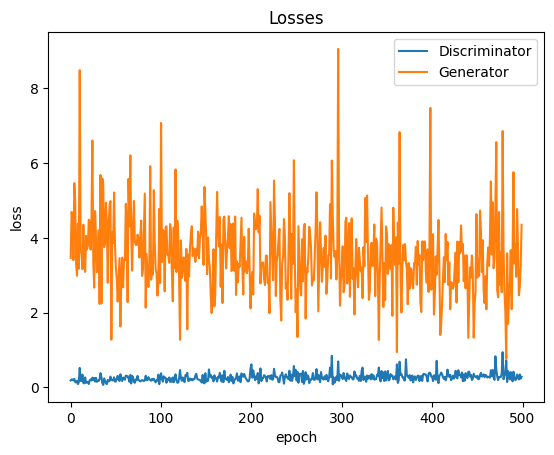

In [75]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

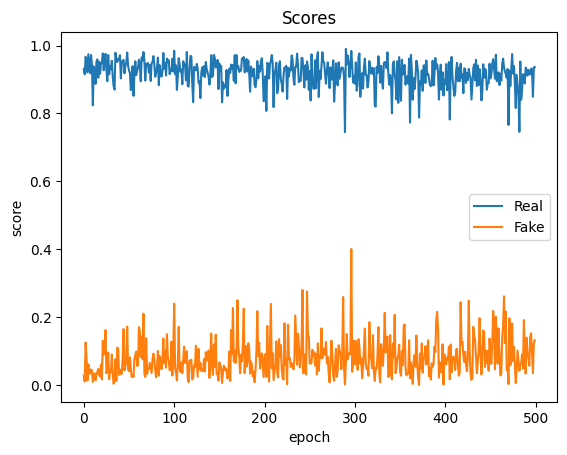

In [76]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');